In [259]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import re
from datetime import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Introduction

In [2]:
df=pd.read_csv("nyc_taxis_weather_jantoaug19s.csv")
df.head()

,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,RatecodeID,congestion_surcharge,extra,fare_amount,improvement_surcharge,mta_tax,...,date,maxtemp,mintemp,avetemp,departuretemp,hdd,cdd,precipitation,newsnow,snowdepth
0,2019-01-17 18:30:40,2019-01-17 18:35:20,162,233,1.0,0.0,1.0,5.0,0.3,0.5,...,1/17/19,33.0,24.0,28.5,-3.7,36.0,0.0,0.00,0.0,0.0
1,2019-01-07 20:45:41,2019-01-07 21:10:25,186,75,1.0,0.0,0.5,19.5,0.3,0.5,...,1/7/19,34.0,25.0,29.5,-3.2,35.0,0.0,0.00,0.0,0.0
2,2019-01-29 10:00:49,2019-01-29 10:07:37,236,237,1.0,0.0,0.0,6.0,0.3,0.5,...,1/29/19,43.0,25.0,34.0,1.1,31.0,0.0,0.23,0.0,0.0
3,2019-01-10 05:54:57,2019-01-10 06:12:44,211,138,1.0,0.0,0.5,29.0,0.3,0.5,...,1/10/19,34.0,28.0,31.0,-1.4,34.0,0.0,0.00,0.0,0.0
4,2019-01-24 08:59:00,2019-01-24 09:12:27,233,170,1.0,0.0,0.0,9.0,0.3,0.5,...,1/24/19,59.0,35.0,47.0,14.5,18.0,0.0,1.33,0.0,0.0


In [3]:
df["pickup_datetime"]=pd.to_datetime(df['pickup_datetime'])
df["dropoff_datetime"]=pd.to_datetime(df['dropoff_datetime'])
df["date"]=pd.to_datetime(df['date'])

In [4]:
df.describe()

,PULocationID,DOLocationID,RatecodeID,congestion_surcharge,extra,fare_amount,improvement_surcharge,mta_tax,passenger_count,payment_type,...,trip_duration_mins,maxtemp,mintemp,avetemp,departuretemp,hdd,cdd,precipitation,newsnow,snowdepth
count,112480.000000,112480.000000,112480.000000,112480.000000,112480.000000,112480.000000,112480.000000,112480.000000,112480.000000,112480.000000,...,112480.000000,112480.000000,112480.000000,112480.000000,112480.000000,112480.000000,112480.000000,112480.000000,112480.000000,112480.000000
mean,162.710837,161.253165,1.052756,1.972424,1.069523,13.068938,0.299957,0.498031,1.571951,1.284299,...,17.901480,62.709468,48.408401,55.558935,0.568466,13.058108,3.868634,0.154170,0.059396,0.074644
std,65.930485,70.204930,0.669901,1.020099,1.237576,11.634544,0.003578,0.031317,1.223892,0.465248,...,71.228883,19.321813,18.013049,18.503470,6.782948,14.374985,5.924168,0.315305,0.374366,0.418558
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,14.000000,2.000000,9.000000,-24.100000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,114.000000,107.000000,1.000000,2.500000,0.000000,6.500000,0.300000,0.500000,1.000000,1.000000,...,6.680000,46.000000,34.000000,40.500000,-3.400000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,162.000000,162.000000,1.000000,2.500000,0.500000,9.500000,0.300000,0.500000,1.000000,1.000000,...,11.130000,66.000000,50.000000,56.500000,0.900000,8.000000,0.000000,0.000000,0.000000,0.000000
75%,233.000000,233.000000,1.000000,2.500000,2.500000,14.500000,0.300000,0.500000,2.000000,2.000000,...,18.200000,80.000000,65.000000,72.000000,4.600000,24.000000,7.000000,0.100000,0.000000,0.000000
max,265.000000,265.000000,99.000000,2.500000,17.500000,314.000000,0.300000,0.500000,6.000000,4.000000,...,1439.020000,95.000000,82.000000,88.500000,20.800000,56.000000,24.000000,1.820000,4.000000,4.000000


In [5]:
df.dtypes

pickup_datetime          datetime64[ns]
dropoff_datetime         datetime64[ns]
PULocationID                      int64
DOLocationID                      int64
RatecodeID                      float64
congestion_surcharge            float64
extra                           float64
fare_amount                     float64
improvement_surcharge           float64
mta_tax                         float64
passenger_count                 float64
payment_type                    float64
store_and_fwd_flag               object
tip_amount                      float64
tolls_amount                    float64
total_amount                    float64
trip_distance                   float64
pickup_dayofweek                  int64
trip_duration_mins              float64
date                     datetime64[ns]
maxtemp                         float64
mintemp                         float64
avetemp                         float64
departuretemp                   float64
hdd                             float64


# 2 Uncovering Key Trends in NYC Taxi Ridership

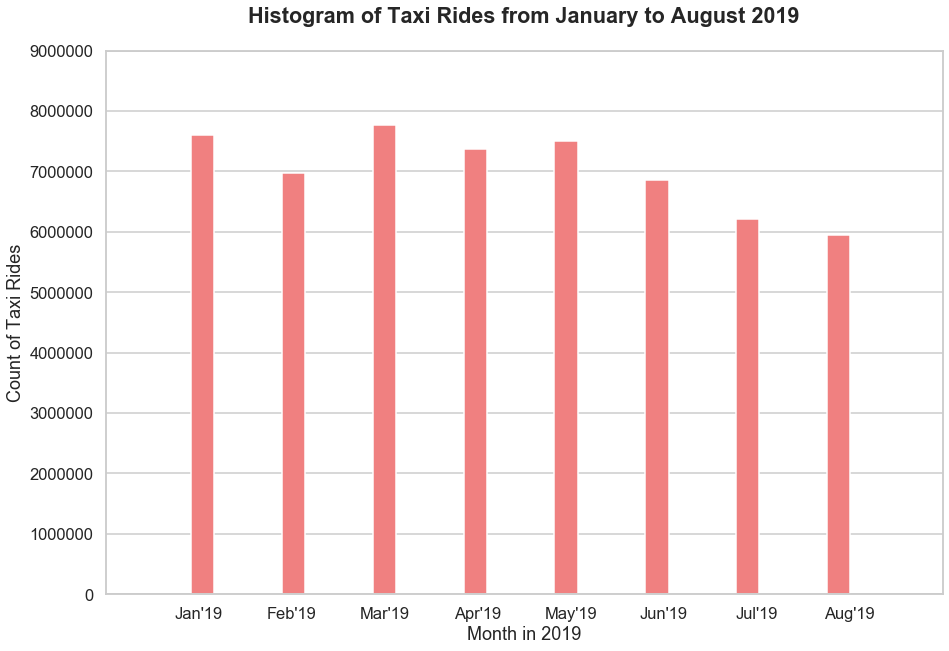

In [6]:
plt.figure(figsize=(15,10))
sns.set(context="talk", style="whitegrid", palette="bright")
g=sns.distplot(df["pickup_datetime"].dt.month, kde=False, hist_kws={"width":0.25,"align":"left","color":"lightcoral", 'alpha': 1})
g.xaxis.grid(b=False)
plt.xlim(0,9)
g.set_xticklabels(["","Jan'19","Feb'19","Mar'19","Apr'19","May'19","Jun'19","Jul'19","Aug'19"])
plt.yticks(g.get_yticks(), (g.get_yticks() * 1/0.002).astype(int))
plt.xlabel("Month in 2019")
plt.ylabel("Count of Taxi Rides")
plt.title("Histogram of Taxi Rides from January to August 2019", fontweight="bold", fontsize="large", y=1.04)
plt.show()

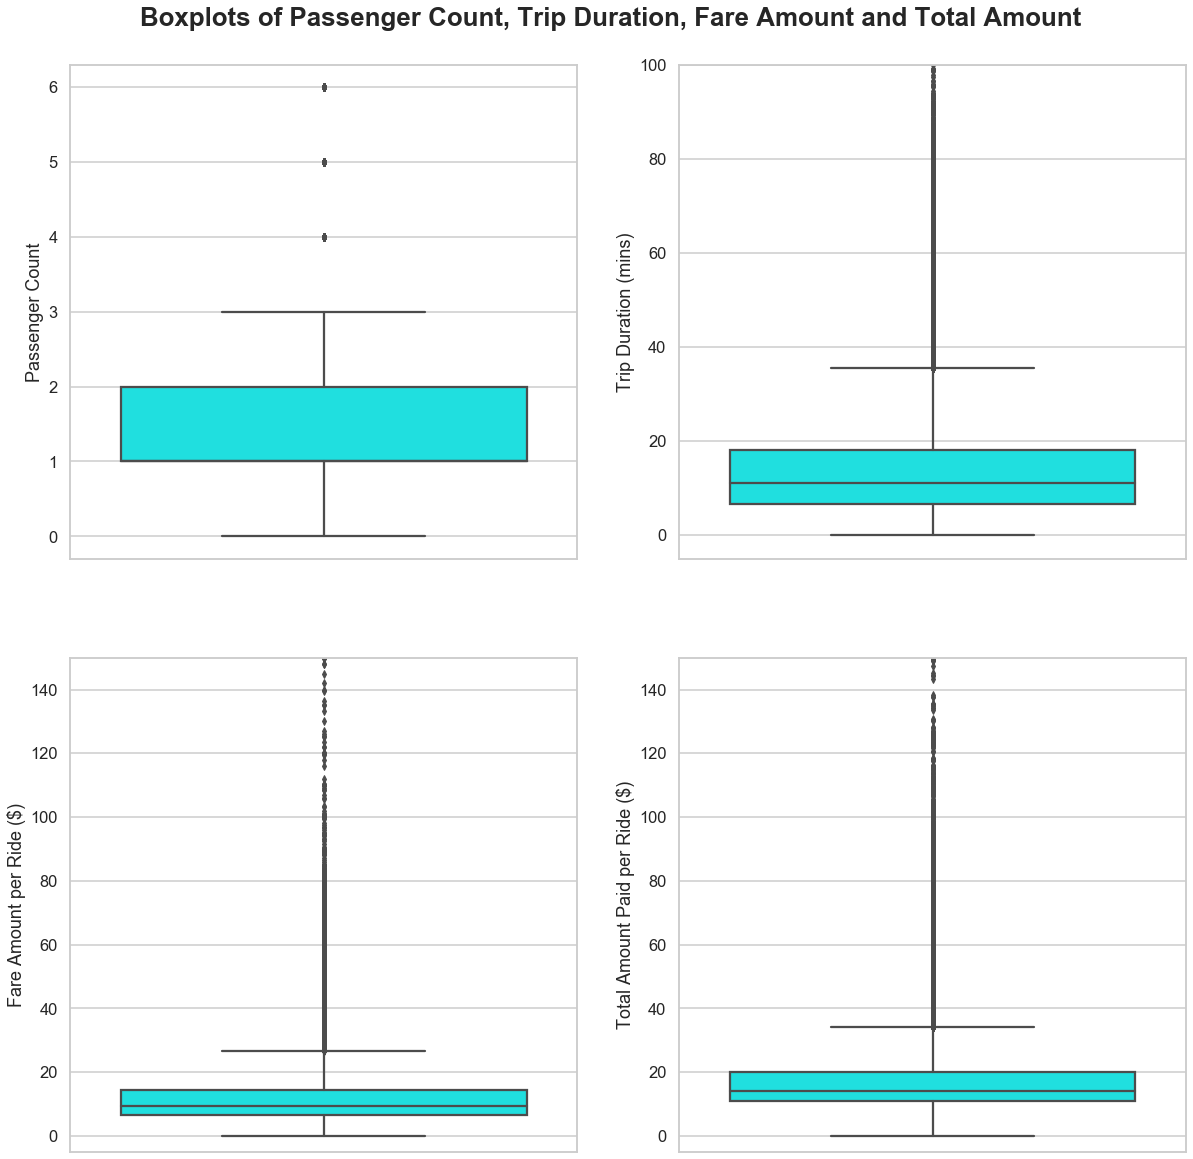

In [7]:
fig,axes=plt.subplots(2,2, figsize=(20,20))

a=sns.boxplot(y=df['passenger_count'], ax=axes[0,0],color="cyan").set(ylabel='Passenger Count')

sns.boxplot(y=df['trip_duration_mins'], ax=axes[0,1],color="cyan").set(ylabel='Trip Duration (mins)')
axes[0,1].set(ylim=(-5, 100))


sns.boxplot(y=df['fare_amount'], ax=axes[1,0],color="cyan").set(ylabel='Fare Amount per Ride ($)')
axes[1,0].set(ylim=(-5, 150))

sns.boxplot(y=df['total_amount'], ax=axes[1,1],color="cyan").set(ylabel='Total Amount Paid per Ride ($)')
axes[1,1].set(ylim=(-5, 150))

fig.suptitle('Boxplots of Passenger Count, Trip Duration, Fare Amount and Total Amount', fontsize="x-large", fontweight="bold", y=0.92)
plt.show()

# 3 A Daily Perspective: Which Variables are the Best Predictors of Daily Trip Counts?

## 3.1 Laying the Foundations

Now, we will explore the question of which variables are best used to predict daily trip counts. This is an interesting question as it reveals the hidden factors that drive commuters' decisions on whether or not to ride a taxi. 

For this part, we will create a new dataframe ("trip_counts_df") that aggregates trip counts by dates. 

In our full dataset, there were two kinds of variables&mdash;trip-basis variables (e.g. `fare_amount`,`trip_distance`) and day-basis variables (e.g. `max_temp`,`date`). Here, we omit all trip-basis variables as they are no longer relevant from a daily perspective. 

In [264]:
trip_count_by_date_df = df.groupby("date")["pickup_datetime"].count()
trip_count_by_date_df = trip_count_by_date_df.to_frame(name="trip_count")
trip_count_by_date_df.reset_index(inplace=True)
trip_counts_df = trip_count_by_date_df.merge(df[["date","maxtemp","mintemp","avetemp","hdd","cdd","precipitation","newsnow","snowdepth","pickup_dayofweek"]], how="inner", on="date")

## 3.2 Dealing with Seasonality

We suspect that day-to-day taxi ridership would have a strong seasonal trend. For instance, large numbers of investment bankers would commute to work by taxi every Monday, but they might be spending time at home or playing golf (and hence not taking the taxi) every Sunday. We will use a time series plot to understand the seasonal trend&mdash;particularly the length of each season and the magnitude of fluctuation across seasons. 

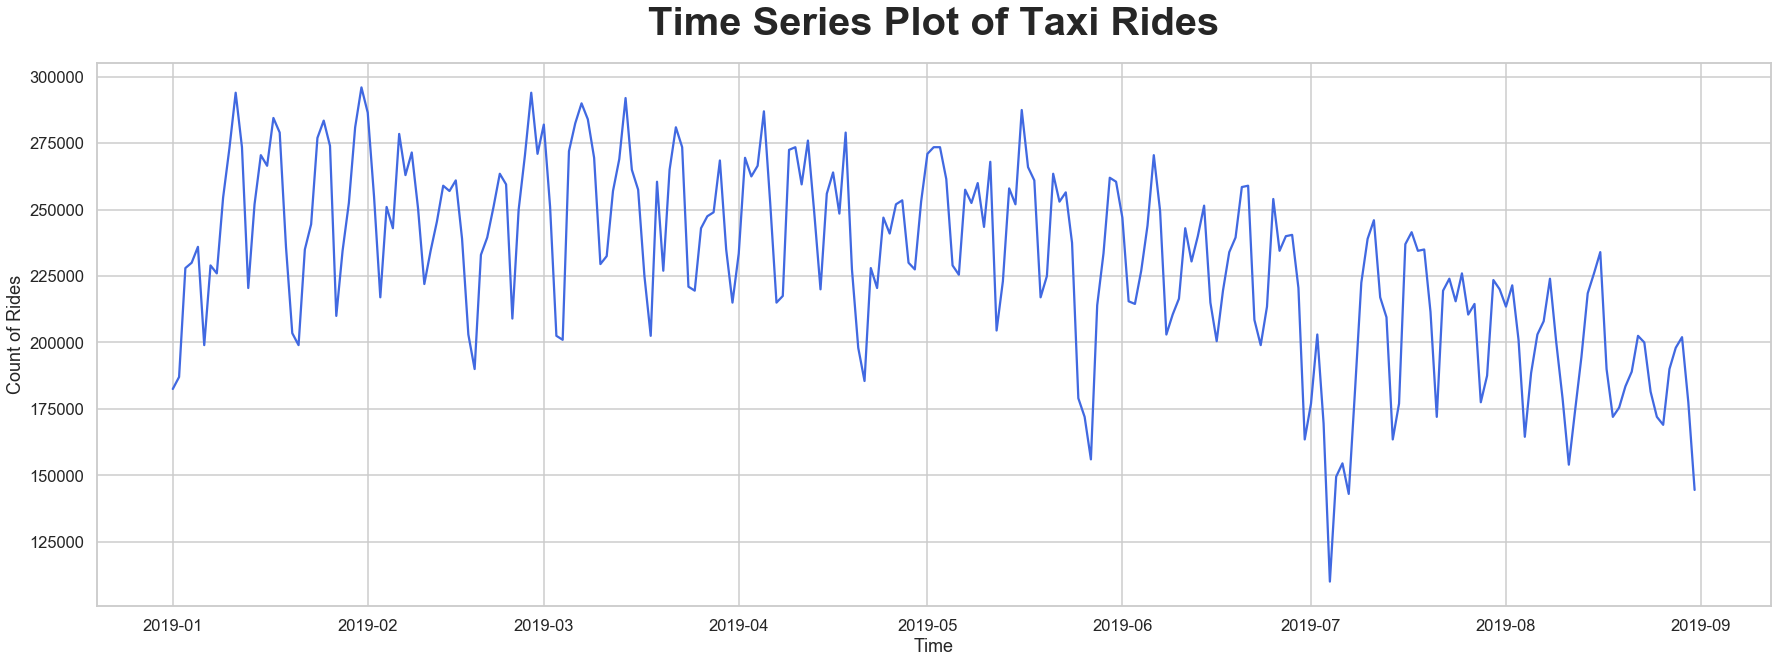

In [265]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(trip_counts_df["date"],trip_counts_df["trip_count"], color="royalblue")
ax.set_title("Time Series Plot of Taxi Rides", fontweight="bold", fontsize="40", y=1.04)
ax.set_xlabel("Time")
ax.set_ylabel("Count of Rides")
ax.set_yticklabels((ax.get_yticks() * 1/0.002).astype(int))
plt.show()

The time series plot shows approximately four peaks and troughs each month, thus indicating a weekly trend. The magnitude of fluctuation is very large, with a difference of up to 75,000 rides between each peak and trough. 

To capture this seasonality in our dataset (and subsequent model), we will create the following variables:

- `isweekend`: a binary variable that codes whether the date is a weekend *(1: yes, 0: no)*
- 6 dummy variables for the day of week (`pickup_monday`, `pickup_tuesday`, `pickup_wednesday`, `pickup_thursday`,`pickup_friday`, `pickup_saturday` and `pickup_sunday`)

In [266]:
trip_counts_df["isweekend"]=np.where(trip_counts_df["pickup_dayofweek"].isin([5,6]),1,0)

PUdayofweek_dummies=pd.get_dummies(trip_counts_df["pickup_dayofweek"])
PUdayofweek_dummies.rename(columns={0:"monday",1:"tuesday",2:"wednesday",3:"thursday",4:"friday",5:"saturday",6:"sunday"}, inplace=True)
trip_counts_df=trip_counts_df.join(PUdayofweek_dummies)

## 3.3 Examining Correlations with `trip_count` through Visualizations

First, we will use a correlation heatmap to identify explanatory variables with noticeable correlations with our response variable (`trip_count`). We are looking out for squares in the heatmap with a reddish or bluish hue (absolute correlations of more than 0.1.

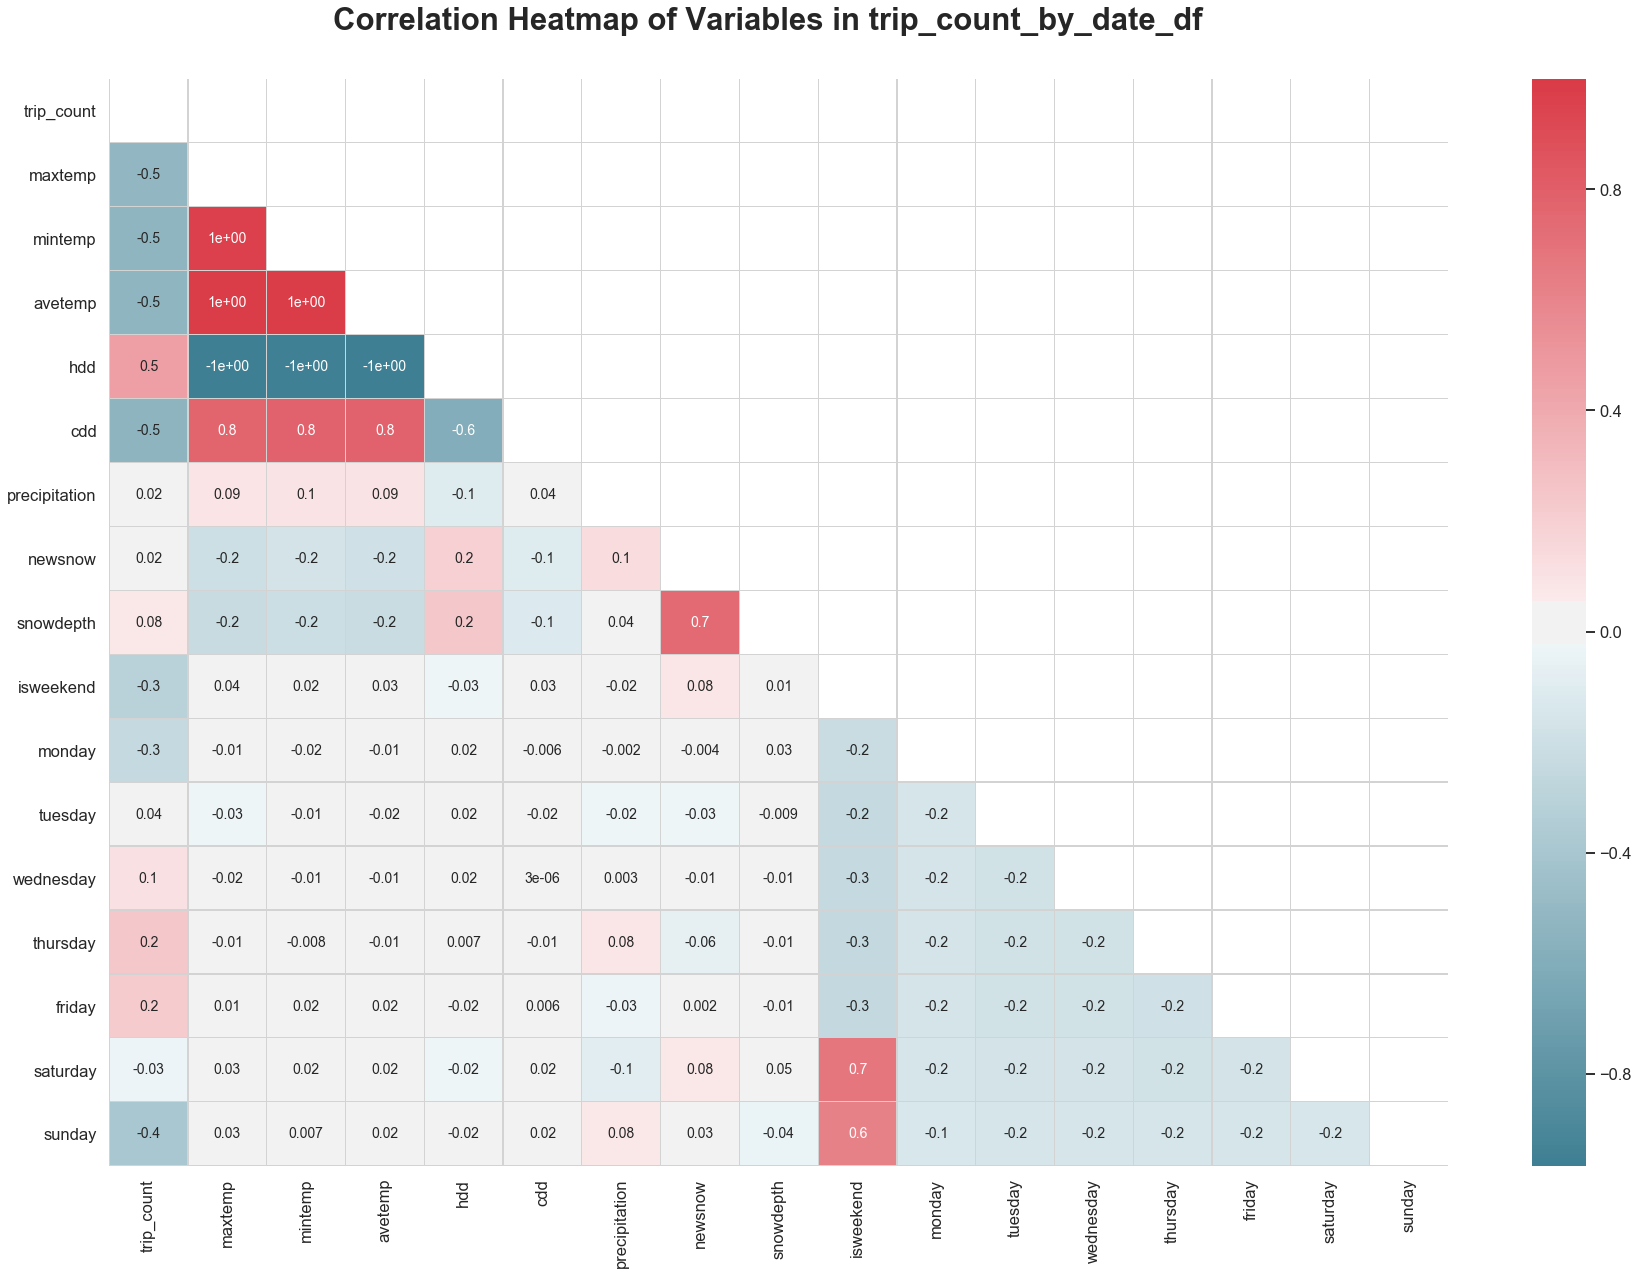

In [267]:
corr=trip_counts_df.drop(columns=["pickup_dayofweek"]).corr()
plt.figure(figsize=(30, 20))
mask = np.tril(trip_counts_df.corr())
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,annot=True,annot_kws={"fontsize":14},fmt = '.1',  cmap=sns.diverging_palette(220, 10, as_cmap=True),  mask = mask, linewidths=0.2, linecolor='lightgray')

#fix for seaborn bug where top and bottom boxes are cut off (adapted from https://github.com/mwaskom/seaborn/issues/1773)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)
plt.suptitle("Correlation Heatmap of Variables in trip_count_by_date_df", fontweight="bold", fontsize="xx-large", x=0.43, y=0.93)
plt.show()

Looking on this heatmap, the explanatory variables that are noteiceably correlated with `trip_count` are:
- Weather variables (`maxtemp`, `mintemp`, `avetemp`, `hdd` and `cdd`)


- Date-related variables, including `isweekend` and the day of week dummies (`monday` to `sunday`)


Contrary to our intial hypotheses that rainy or snowy weather would increase taxi ridership, precipitation and snowfall are have only negligible correlations with `trip_count`. 

We will proceed with some visualizations to better understand the strength and direction of the relationship between these explanatory variables and daily taxi ridership. 

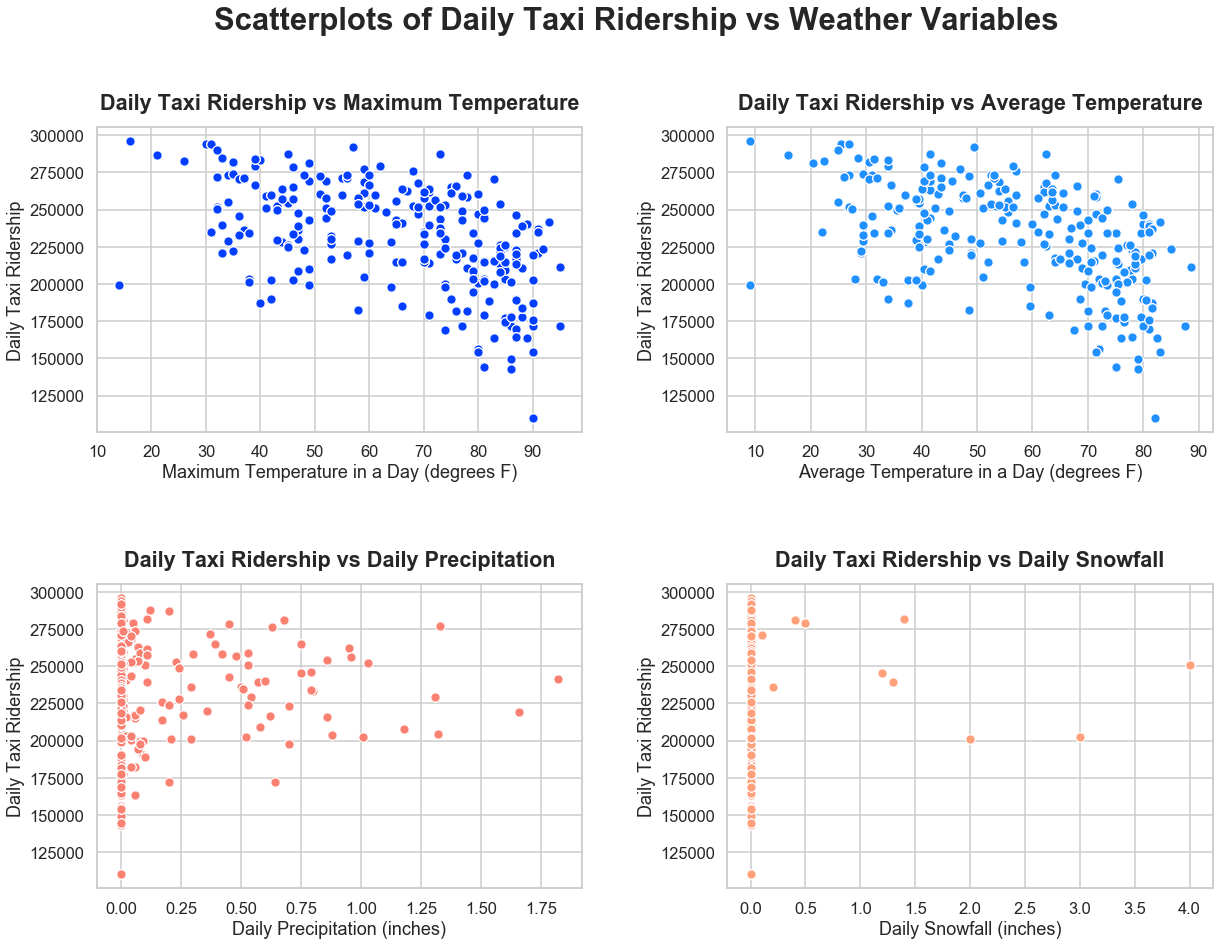

In [268]:
fig,axes=plt.subplots(2,2, figsize=(20,14))

sns.scatterplot(trip_counts_df["maxtemp"],trip_counts_df["trip_count"], ax=axes[0,0]).set(ylabel='Daily Taxi Ridership', xlabel="Maximum Temperature in a Day (degrees F)")
axes[0,0].set_yticklabels((axes[0,0].get_yticks() * 1/0.002).astype(int))
axes[0,0].set_title("Daily Taxi Ridership vs Maximum Temperature", fontweight="bold", fontsize="large", y=1.04)

sns.scatterplot(trip_counts_df["avetemp"],trip_counts_df["trip_count"], ax=axes[0,1], color="dodgerblue").set(ylabel='Daily Taxi Ridership', xlabel="Average Temperature in a Day (degrees F)")
axes[0,1].set_yticklabels((axes[0,1].get_yticks() * 1/0.002).astype(int))
axes[0,1].set_title("Daily Taxi Ridership vs Average Temperature", fontweight="bold", fontsize="large", y=1.04)

sns.scatterplot(trip_counts_df["precipitation"],trip_counts_df["trip_count"], ax=axes[1,0], color="salmon").set(ylabel='Daily Taxi Ridership', xlabel="Daily Precipitation (inches)")
axes[1,0].set_yticklabels((axes[1,0].get_yticks() * 1/0.002).astype(int))
axes[1,0].set_title("Daily Taxi Ridership vs Daily Precipitation", fontweight="bold", fontsize="large", y=1.04)

sns.scatterplot(trip_counts_df["newsnow"],trip_counts_df["trip_count"], ax=axes[1,1], color="lightsalmon").set(ylabel='Daily Taxi Ridership', xlabel="Daily Snowfall (inches)")
axes[1,1].set_yticklabels((axes[1,1].get_yticks() * 1/0.002).astype(int))
axes[1,1].set_title("Daily Taxi Ridership vs Daily Snowfall", fontweight="bold", fontsize="large", y=1.04)

plt.subplots_adjust(hspace = 0.5, wspace=0.3)
plt.suptitle("Scatterplots of Daily Taxi Ridership vs Weather Variables", fontweight="bold", fontsize="xx-large", y=1)

plt.show()



The top two scatterplots show that both maximum temperature (a proxy of daytime temperature) and average temperature are negatively correlated to daily taxi ridership. With an increase in maximum temperature, especially above the 60-degree mark, New Yorkers rely less on taxis. Perhaps, they turn to other forms of transportation such as the walking or Citi Bikes that are much more pleasurable without the bitter cold. 

Though `precipitation` appeared uncorrelated in the correlation heatmap, the bottom left scatterplot shows that precipitation is still related to taxi ridership. Low precipitation levels do not guarantee low daily taxi ridership (as evidenced by the high trip counts occurring on 0-precipitation days), but high precipitation levels are always accompanied by at least a moderate level of taxi ridership. 

Likewise, for daily snowfall, high snowfall days always have at least an moderate level of taxi ridership, but low- and no-snowfall days have trip counts spanning the spectrum of low to high. Perhaps, the weak and ambiguous relationship between `newsnow` and `trip_counts` is due to the very few data points for snowy days (10 out of 243 days). 

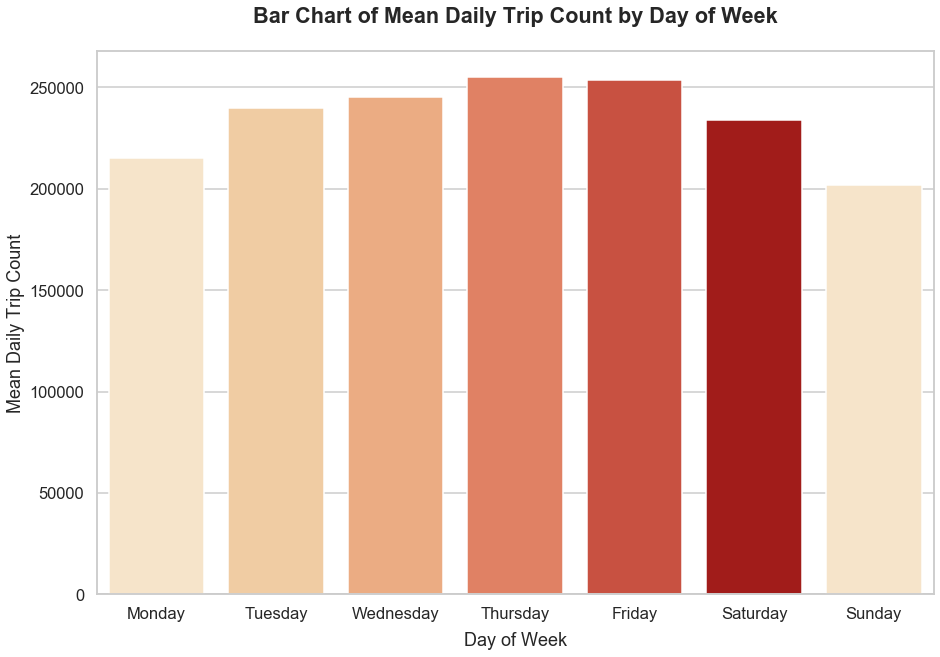

In [283]:
plt.figure(figsize=(15,10))
ax=sns.barplot(trip_counts_df["pickup_dayofweek"], trip_counts_df["trip_count"], ci=None, palette=sns.color_palette("OrRd"))
ax.set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
ax.set_yticklabels((ax.get_yticks() * 1/0.002).astype(int))
ax.set_ylabel('Mean Daily Trip Count')
ax.set_xlabel('Day of Week', labelpad=10)
plt.title("Bar Chart of Mean Daily Trip Count by Day of Week", fontweight="bold", fontsize="large", y=1.04)
plt.show()

Having deduced weekly seasonality from the time series previously, we would now like to analyze how taxi ridership actually rises and falls within a week. 

Across the days of a week, the mean daily trip count is lowest on Sunday, which is sensible as taxi commutes to work do not occur on a rest day. Saturday has a higher mean trip count that Sunday, as it is only a partial rest day for some employees and many Friday night party-goers would ride taxis home on early Saturday morning. 

After Sunday, taxi ridership climbs day-by-day to reach its peak on Thursday, before falling as the weekend arrives. 

## 3.4 Linear Regression

### 3.4.1 Building of Model

We will use the Akaike’s Information Criterion (AIC) to select a linear regression model with the best relative quality—the best balance between goodness of fit and complexity. 

In [336]:
def minAIC_OLS(X,y):
    variables = X.columns
    model = sm.OLS(y,X[variables]).fit()
    while True:
        print(f'old model aic: {model.aic}')
        maxp = np.max(model.pvalues)
        newvariables = variables[model.pvalues < maxp]
        newmodel = sm.OLS(y,X[newvariables]).fit()
        print(f'new model aic: {newmodel.aic}')
        if newmodel.aic < model.aic:
            model = newmodel
            variables = newvariables
        else:
            break
    return model,variables
linear_model_cols=["maxtemp","avetemp", "precipitation","hdd","cdd","newsnow","snowdepth","tuesday","wednesday","thursday","friday","saturday","sunday"]
X=trip_counts_df[linear_model_cols]
X = sm.add_constant(X)
print(f"Initial Variables are {np.array(X.columns)}\n")
y=trip_counts_df["trip_count"]
new_linear_model , linear_variables = minAIC_OLS(X,y)
new_linear_model = sm.OLS(y,X[linear_variables]).fit()
print(f"After Optimization, New model AIC is {new_linear_model.aic}\n")
print(f"After Optimization, New Variables are {np.array(new_linear_model.params.index)}")

Initial Variables are ['const' 'maxtemp' 'avetemp' 'precipitation' 'hdd' 'cdd' 'newsnow'
 'snowdepth' 'tuesday' 'wednesday' 'thursday' 'friday' 'saturday' 'sunday']

old model aic: 1153183.81269853
new model aic: 1153434.5272603855
After Optimization, New model AIC is 1153183.81269853

After Optimization, New Variables are ['const' 'maxtemp' 'avetemp' 'precipitation' 'hdd' 'cdd' 'newsnow'
 'snowdepth' 'tuesday' 'wednesday' 'thursday' 'friday' 'saturday' 'sunday']


Since the AIC cannot be decreased at all, it is impossible to achieve a better-fitting model (that is not overfitted) by removing any of the explanatory variables that we currently have. Note that we omitted the `monday` dummy variable to avoid overparameterizing our model. 

In [337]:
results = new_linear_model.summary()
results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             trip_count   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                 1.419e+04
Date:                Tue, 12 May 2020   Prob (F-statistic):               0.00
Time:                        23:02:19   Log-Likelihood:            -5.7658e+05
No. Observations:              112480   AIC:                         1.153e+06
Df Residuals:                  112466   BIC:                         1.153e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1474.3933     32.313     45.628      0.000    1411.060    1537.726
maxtemp           1.8453      0.050     36.681      0.000       1.747       1.944
avetemp         -18.2158      0.504    -36.135      0.000     -19.204     -17.228
precipitation    20.4618      0.402     50.929      0.000      19.674      21.249
hdd             -15.1652      0.499    -30.396      0.000     -16.143     -14.187
cdd              11.9526      0.499     23.942      0.000      10.974      12.931
newsnow         -15.4859      0.497    -31.160      0.000     -16.460     -14.512
snowdepth         7.0404      0.443     15.905      0.000       6.173       7.908
tuesday          50.6015      0.465    108.785      0.000      49.690      51.513
wednesday        60.0854      0.465    129.259      0.000      59.174      60.996
thursday         78.7001      0.460    171.033      0.000      77.798      79.602
friday           80.1435      0.460    174.092      0.000      79.241      81.046
saturday         42.7450      0.471     90.666      0.000      41.821      43.669
sunday          -24.8431      0.491    -50.572      0.000     -25.806     -23.880
==============================================================================
Omnibus:                    18918.490   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36924.754
Skew:                          -1.036   Prob(JB):                         0.00
Kurtosis:                       4.893   Cond. No.                     2.35e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Performing the joint F-test at the 5% significance level, we see that the F statistic's p-value is 0. Hence, we reject the null hypothesis that none of the explanatory variables are related to `trip_counts`. In other words, our model fits the data better than an intercept-only model. 

An R-squared value of 0.62 means that 62% of the variation in `trip_counts` about its mean can be explained by our current fitted model. This is within the range of our expectations as weather and seasonality variables alone are insufficient to explain the full trend in taxi ridership. It is possible that additional predictors could boost the explanatory power of our model, or it could just be that taxi ridership trends have a fair amount of unexplainable variability. 

Using a two-tailed t-test at a 5% significant level, we reject the null hypothesis that a variable's coefficient is 0 if its upper-tail p-value is below 0.025. All the explanatory variables have p-values of 0 (<0.025) and are thus significant.  

To draw meaningful interpretations from the results, we must multiply each coefficient by 1/0.002, as we sampled only 0.002 of all taxi rides in the raw dataset. 

In [325]:
scaled_value_coefs=pd.DataFrame(new_linear_model.params*1/0.002)
scaled_value_coefs.rename(columns={0: "Scaled Values"}, inplace=True)
scaled_value_coefs

,Scaled Values
const,737196.649243
maxtemp,922.636983
avetemp,-9107.903535
precipitation,10230.886506
hdd,-7582.623825
cdd,5976.279046
newsnow,-7742.957362
snowdepth,3520.224956
isweekend,2983.646194
tuesday,25300.734614


Some key findings from the linear regression model include:

- Echoing the negative correlations between temperatures and `trip_count` we saw earlier, a 1-degree F increase in `avetemp` (average daily temperature) is linked to a drop in daily taxi ridership by 9,107 rides, when covariates are held constant. An increase in `maxtemp` is linked to a surprising increase in daily trip counts, suggesting that the negative correlations we observed earlier for `maxtemp` could be due to its interaction with `avetemp`. 


- A 1-inch increase in precipitation is linked to a 10,230 increase in daily trip counts, holding covariates constant, suggesting that more rain indeed spurs taxi commutes. There is a surprising relationship observed in snowfall. While `snowdepth` (accumulated snow) is linked to a increase in taxi ridership, `newsnow` (new daily snowfall) is associated with a decrease in taxi ridership when covariates are held constant. It is possible that new snowfall affects the safety of roads more than accumulated snow thus discourages people from even commuting work by taxi. 


- Day of week has an important effect on `trip_count`. A Sunday is linked to a decrease in daily trip counts by 15,405 rides, as relative to a Monday. Thursday and Friday are linked to the largest increases in taxi ridership as compared to Monday, which matches the intuition we got in the bar chart earlier. Overall, we can see an day-by-day increase in taxi ridership from Monday till Friday, before a sharp drop in taxi ridership on Saturday and a sharper drop on Sunday. This seasonality plays an important role in our model's fit&mdash;when we excluded day of week dummies, our R-squared is almost halved from 0.621 to 0.341.


### 3.4.2 Evaluation of Model 

For us to be able to draw valid inferences, the linear regression model has to satisfy four assumptions: 

1. Model is linear in the predictors
2. Residuals have a constant variance (are homoskedastic)
3. Residuals are mutually independent
4. Residuals are normally distributed

We will test each of the assumptions above. 

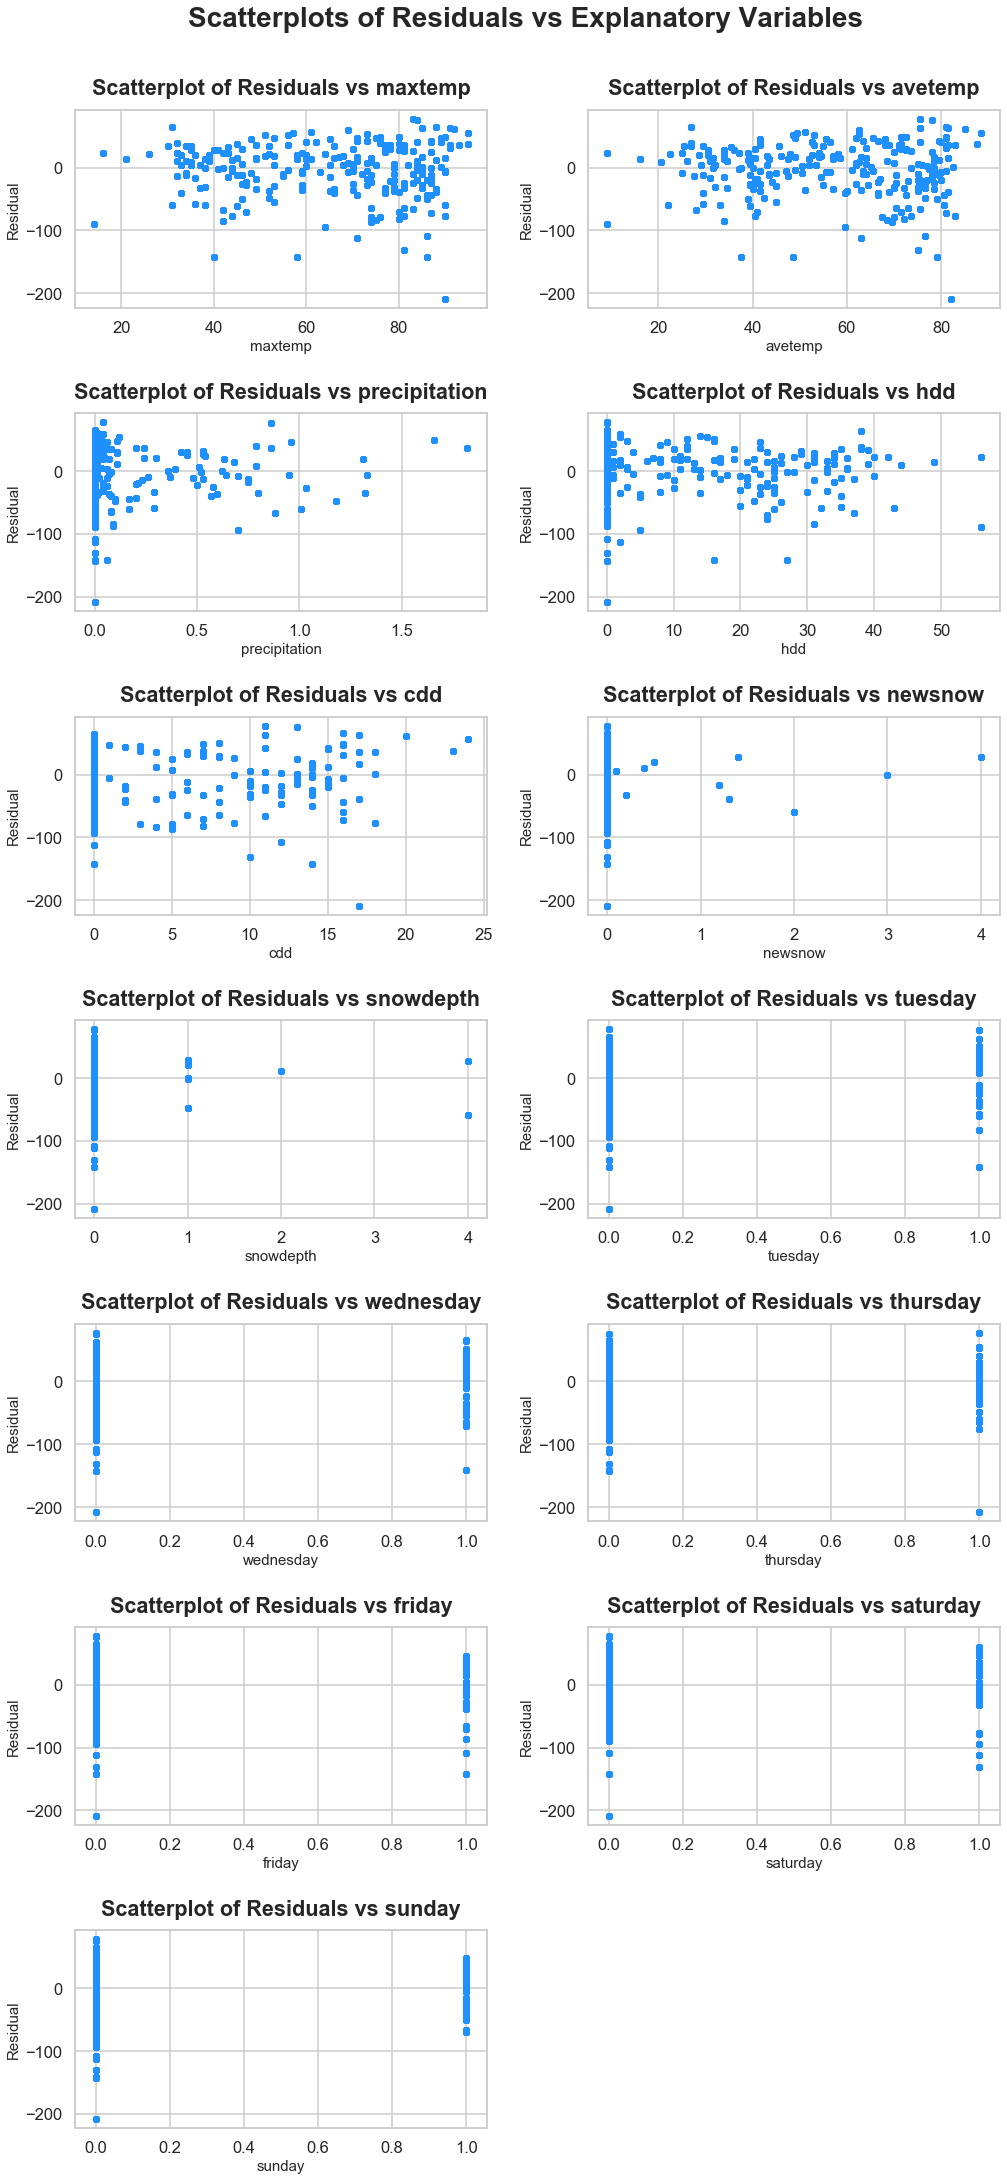

In [362]:
f, ax = plt.subplots(nrows=7, ncols=2, figsize=(15,30))
f.delaxes(ax[6,1])
f.tight_layout(pad=3, h_pad=4)

for c, colname in enumerate(linear_model_cols):
    rowindex = c//2
    colindex = 0 if c%2==0 else 1
    ax[rowindex][colindex].scatter(trip_counts_df[f"{colname}"],res, color="dodgerblue", marker=".")
    ax[rowindex][colindex].set_title(f"Scatterplot of Residuals vs {colname}", fontweight="bold", fontsize="large", pad=15)
    ax[rowindex][colindex].set_ylabel("Residual", fontsize=15)
    ax[rowindex][colindex].set_xlabel(f"{colname}", fontsize=15)
    f.suptitle('Scatterplots of Residuals vs Explanatory Variables', fontsize="28", fontweight="bold", y=1.02)
plt.show()

1st Assumption Satisfied: Since the average values of the residuals do not depend on the values of each explanatory variable, our model is indeed linear in its predictors. 

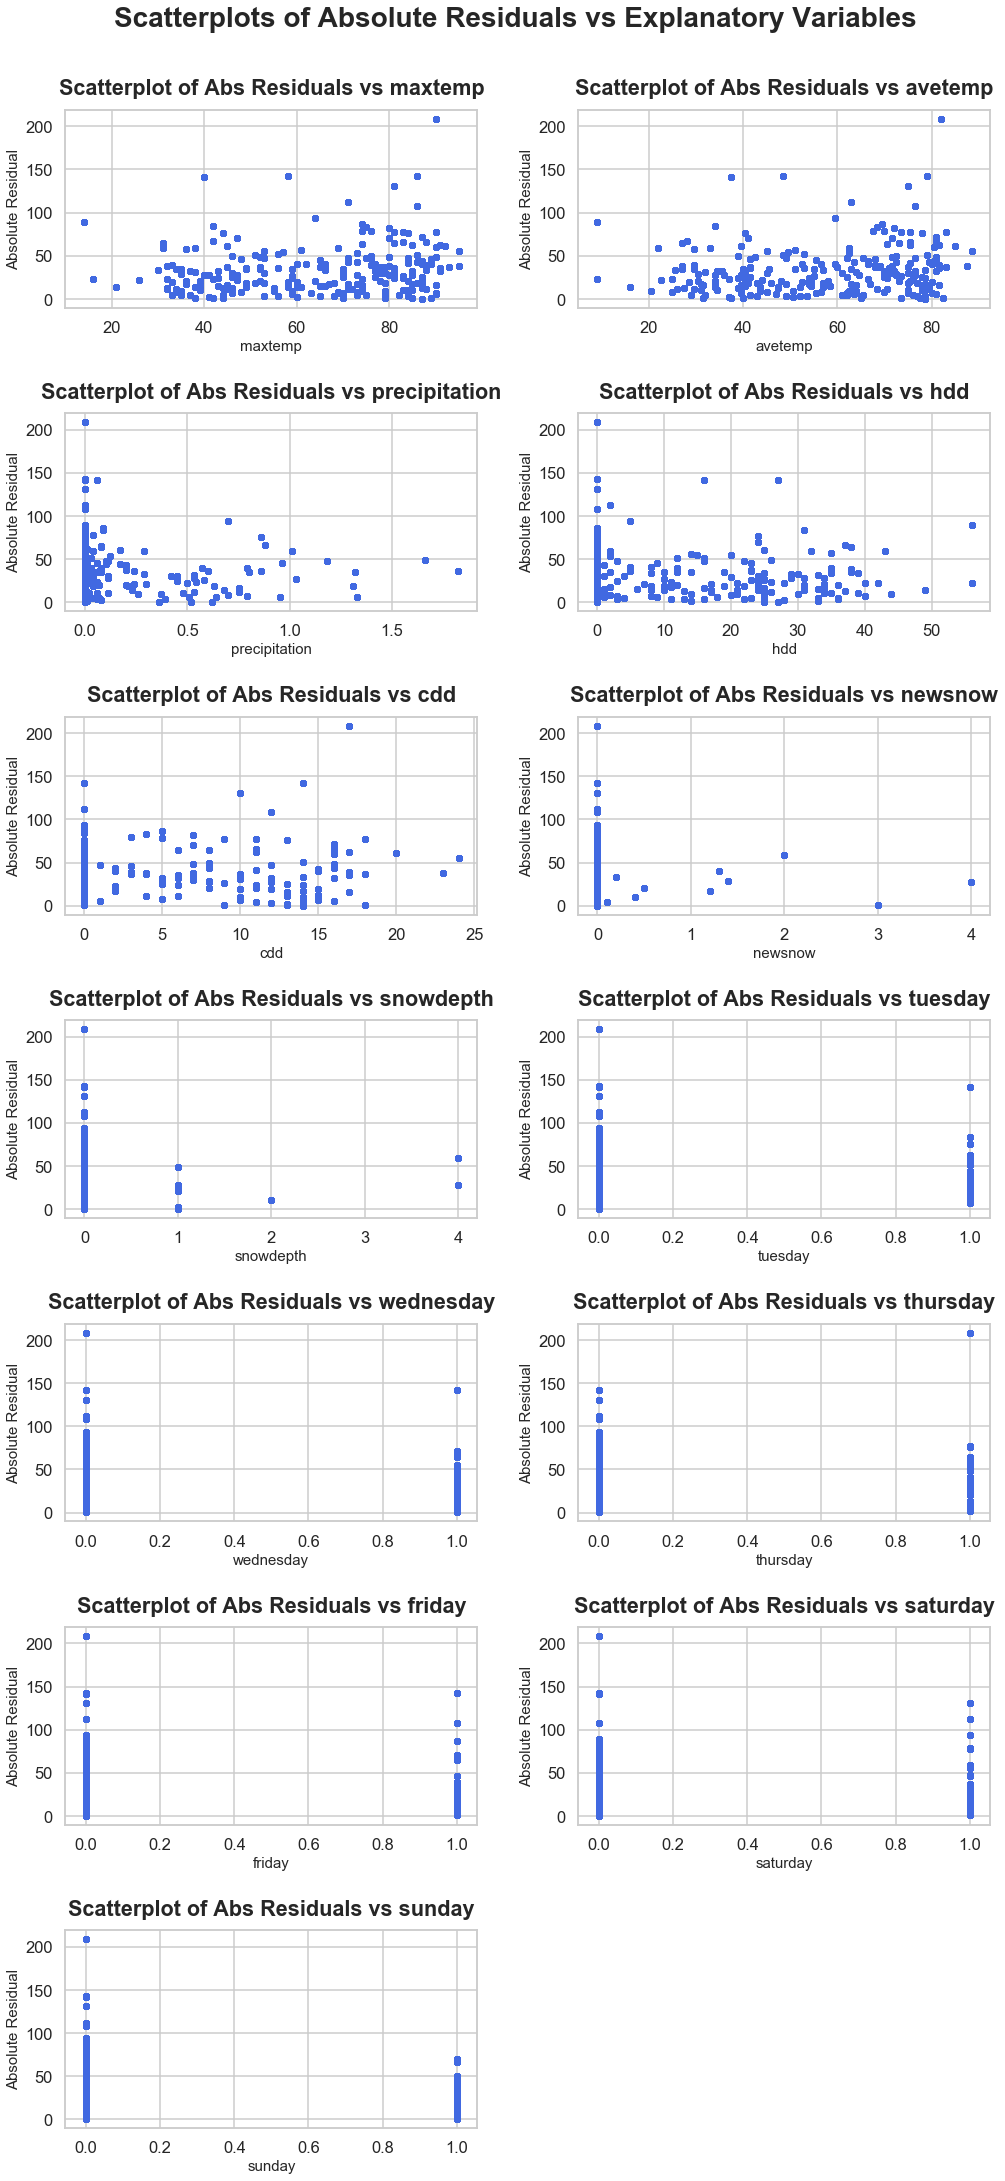

In [365]:
abs_res=np.abs(np.array(res))
f, ax = plt.subplots(nrows=7, ncols=2, figsize=(15,30))
f.delaxes(ax[6,1])
f.tight_layout(pad=3, h_pad=4)

for c, colname in enumerate(linear_model_cols):
    rowindex = c//2
    colindex = 0 if c%2==0 else 1
    ax[rowindex][colindex].scatter(trip_counts_df[f"{colname}"],abs_res, color="royalblue", marker=".")
    ax[rowindex][colindex].set_title(f"Scatterplot of Abs Residuals vs {colname}", fontweight="bold", fontsize="large", pad=15)
    ax[rowindex][colindex].set_ylabel("Absolute Residual", fontsize=15)
    ax[rowindex][colindex].set_xlabel(f"{colname}", fontsize=15)
    f.suptitle('Scatterplots of Absolute Residuals vs Explanatory Variables', fontsize="28", fontweight="bold", y=1.02)
plt.show()

2nd Assumption Satisfied: Since the distribution of absolute residuals does not depend on value of each explanatory variable, the variance of the residuals is constant. 

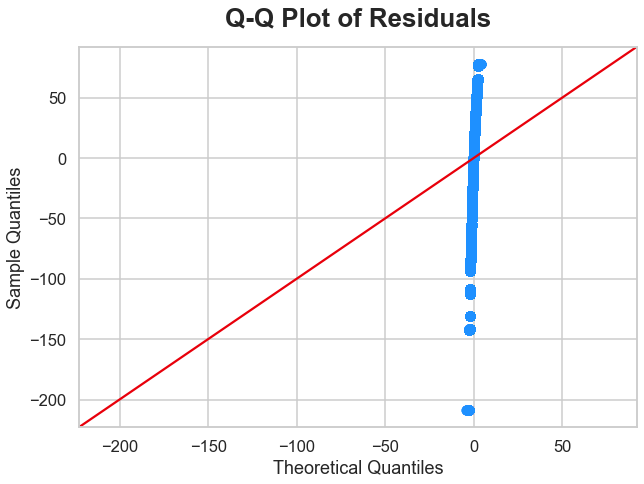

In [366]:
f, ax = plt.subplots(figsize=(10,7))
fig = sm.qqplot(res, line="45",ax=ax, color="dodgerblue")
ax.set_title("Q-Q Plot of Residuals", fontweight="bold", fontsize="x-large", y=1.04)
plt.show()

3rd Assumption Not Satisfied: Since the Q-Q plot of the residuals does not yield a straight 45-degree line, the residuals are not normally distributed.

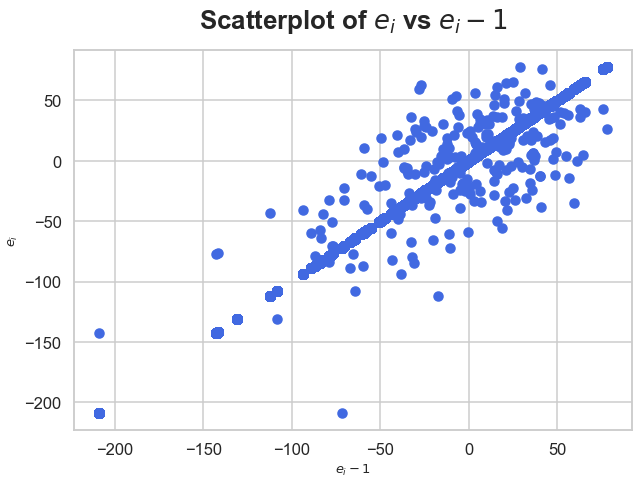

In [342]:
res=new_linear_model.resid
plt.figure(figsize=(10,7))
plt.scatter(res[:-1], res[1:], color="royalblue")
plt.title("Scatterplot of $e_i$ vs $e_i-1$", fontweight="bold", fontsize="x-large", y=1.04)
plt.ylabel("$e_i$", fontsize=13)
plt.xlabel("$e_i-1$", fontsize=13)
plt.show()

4th Assumption Not Satisfied: Since there is a clear relationship between consecutive residuals, residuals are not mutually independent. This is most likely due to the vulnerability of time series regression models to serial correlation (read more at http://people.duke.edu/~rnau/testing.htm). 

Overall, given that our linear model violates the assumptions of normal and mutually independent residuals, we would not proceed to predict `trip_counts` using it. The predictions that it generates could potentially be biased or misleading. 

START OF SECTION: CONSIDER RESHUFFLING/PUTTING BEFORE LINEAR REGRESSION MODEL

## How is Taxi Ridership Correlated with Temperature?

Looking on this heatmap, we drop all the features that have close to negligible correlation the only explanatory variables correlated with `trip_count`:
- The daily minimum and maximum temperature (`mintemp`,`maxTemp`) 
- The daily average temperature (`avetemp`)
These variables are similar with one another so we chose to look at maxTemp and aveTemp.

We will proceed with some visualizations to better understand the strength and direction of the relationship between these explanatory variables and `trip_count`. 

In [122]:
trip_count_weather_by_date_df = trip_count_by_date_df.merge(df[["date","maxtemp","avetemp"]], how="inner", on="date")
trip_count_weather_by_date_df = trip_count_weather_by_date_df.groupby("date").first()
trip_count_weather_by_date_df.head()

,trip_count,maxtemp,avetemp
date,,,
2019-01-01,365,58.0,48.5
2019-01-02,374,40.0,37.5
2019-01-03,456,44.0,40.5
2019-01-04,460,47.0,41.0
2019-01-05,472,47.0,44.0


In [123]:
trip_count_weather_by_date_df.describe()

,trip_count,maxtemp,avetemp
count,243.000000,243.000000,243.000000
mean,462.880658,64.234568,57.047325
std,69.788747,19.367864,18.582039
min,220.000000,14.000000,9.000000
25%,419.500000,47.000000,40.750000
50%,469.000000,69.000000,61.000000
75%,517.500000,81.000000,73.500000
max,592.000000,95.000000,88.500000


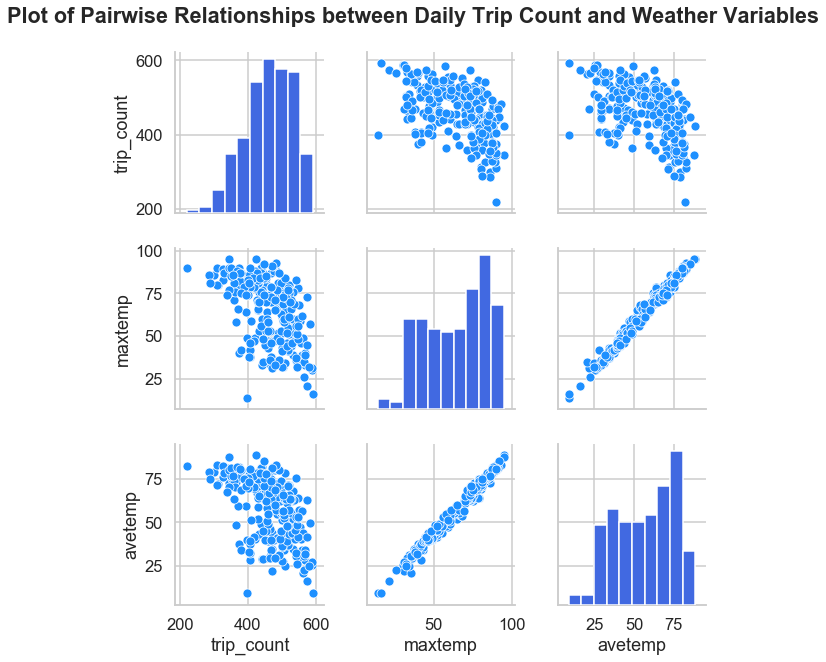

In [12]:
g=sns.pairplot(trip_count_weather_by_date_df, height=3, plot_kws={"color":"dodgerblue"}, diag_kws={"color":"royalblue"})
g.fig.suptitle("Plot of Pairwise Relationships between Daily Trip Count and Weather Variables", fontweight="bold", fontsize="large",y=1.03)
plt.show()

### Maximum Temperature

In [13]:
np.corrcoef(trip_count_weather_by_date_df["maxtemp"],trip_count_weather_by_date_df["trip_count"])

array([[ 1.        , -0.52443419],
       [-0.52443419,  1.        ]])

An increase in daytime temperature is correlated with a decrease in daily taxi ridership. There is a moderately strong negative correlation. 

In [15]:
maxTemp_model = LinearRegression().fit(trip_count_weather_by_date_df[["maxtemp"]],trip_count_weather_by_date_df[["trip_count"]])
print("Slope:",maxTemp_model.coef_[0],"Intercept:",maxTemp_model.intercept_)

Slope: [-1.88970783] Intercept: [584.26522438]


According to the linear regression model, for every degree increase in maxTemp, the number of trips in a day decreases by ~2.

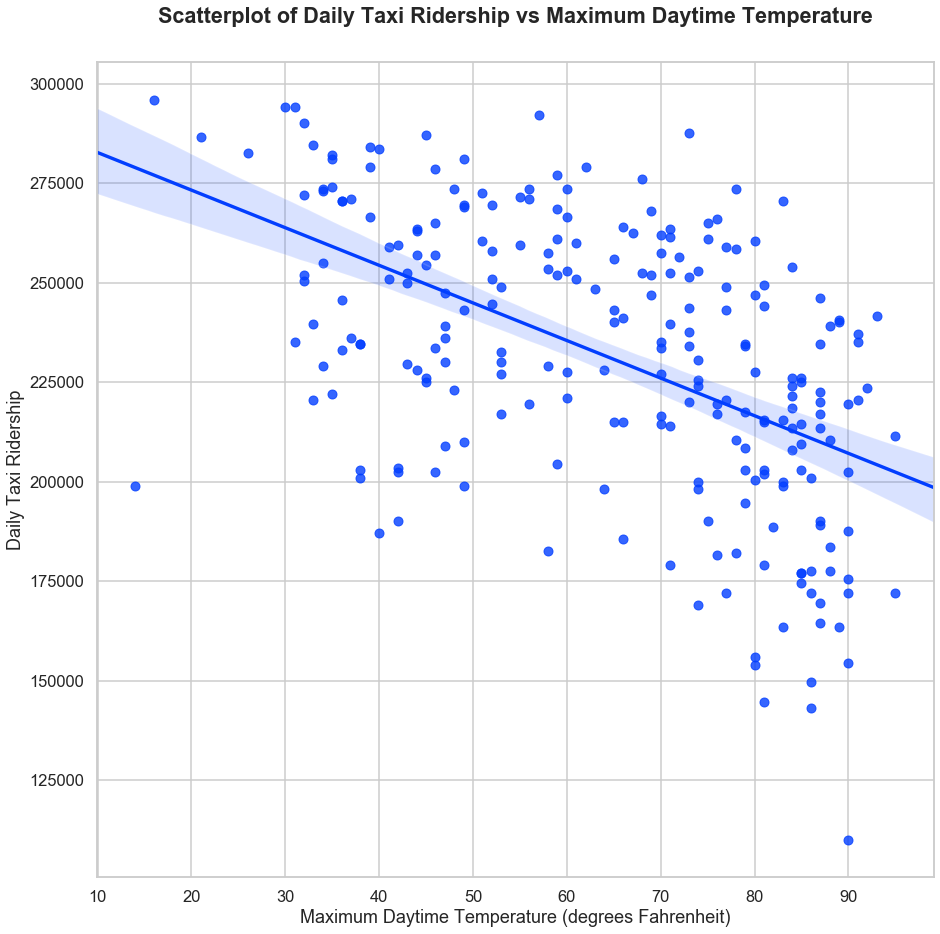

In [16]:
fig, ax = plt.subplots(figsize=(15,15))
sns.regplot(trip_count_weather_by_date_df["maxtemp"],trip_count_weather_by_date_df["trip_count"]).set(ylabel='Daily Taxi Ridership', xlabel="Maximum Daytime Temperature (degrees Fahrenheit)")
ax.set_yticklabels((ax.get_yticks() * 1/0.002).astype(int))
plt.title("Scatterplot of Daily Taxi Ridership vs Maximum Daytime Temperature", fontweight="bold", fontsize="large", y=1.04)
plt.show()

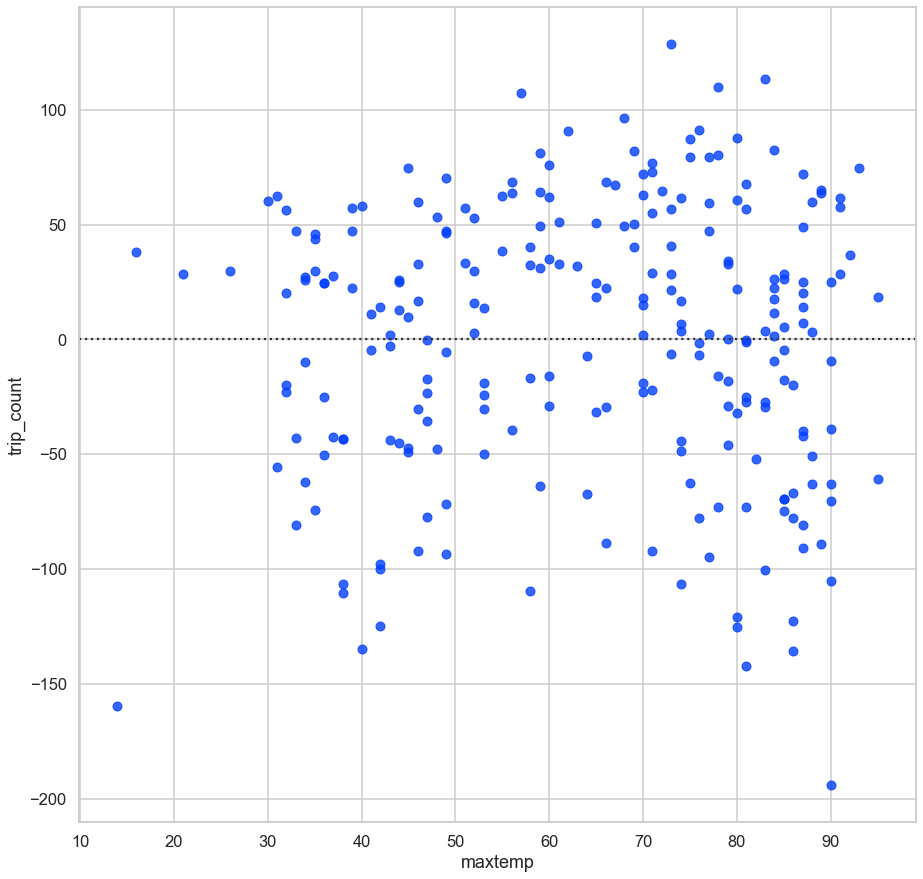

In [17]:
plt.figure(figsize=(15,15))
sns.residplot(trip_count_weather_by_date_df["maxtemp"],trip_count_weather_by_date_df["trip_count"])
plt.show()

Looking at the residual plot, the points seem to be randomly dispersed which shows the the linear model is an appropiate model.

### Average Temperature

In [18]:
np.corrcoef(trip_count_weather_by_date_df["avetemp"],trip_count_weather_by_date_df["trip_count"])

array([[ 1.        , -0.53345522],
       [-0.53345522,  1.        ]])

An increase in daily average temperature is correlated with a decrease in daily taxi ridership. There is a moderately strong negative correlation.  

In [19]:
maxTemp_model = LinearRegression().fit(trip_count_weather_by_date_df[["maxtemp"]],trip_count_weather_by_date_df[["trip_count"]])
print("Slope:",maxTemp_model.coef_[0],"Intercept:",maxTemp_model.intercept_)

Slope: [-1.88970783] Intercept: [584.26522438]


According to the linear regression model, for every degree increase in maxTemp, the number of trips in a day decreases by ~2.

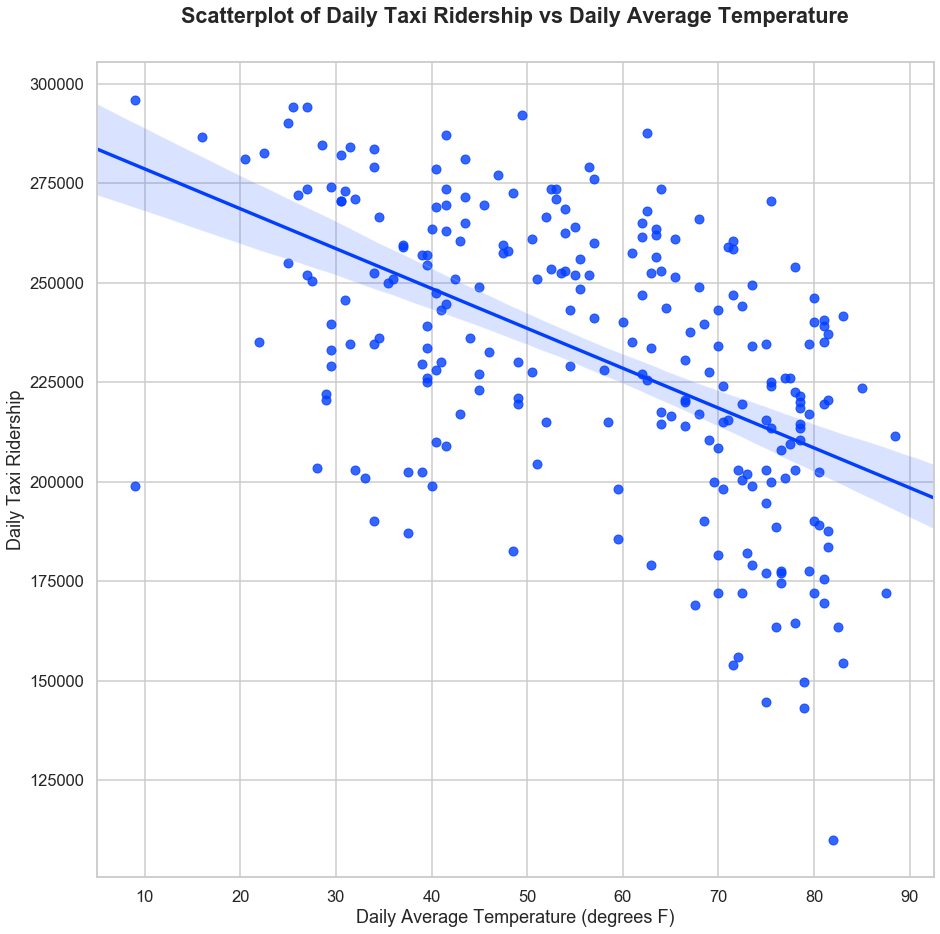

In [20]:
fig,ax=plt.subplots(figsize=(15,15))
sns.regplot(trip_count_weather_by_date_df["avetemp"],trip_count_weather_by_date_df["trip_count"]).set(ylabel='Daily Taxi Ridership', xlabel="Daily Average Temperature (degrees F)")
ax.set_yticklabels((ax.get_yticks() * 1/0.002).astype(int))
plt.title("Scatterplot of Daily Taxi Ridership vs Daily Average Temperature", fontweight="bold", fontsize="large", y=1.04)
plt.show()

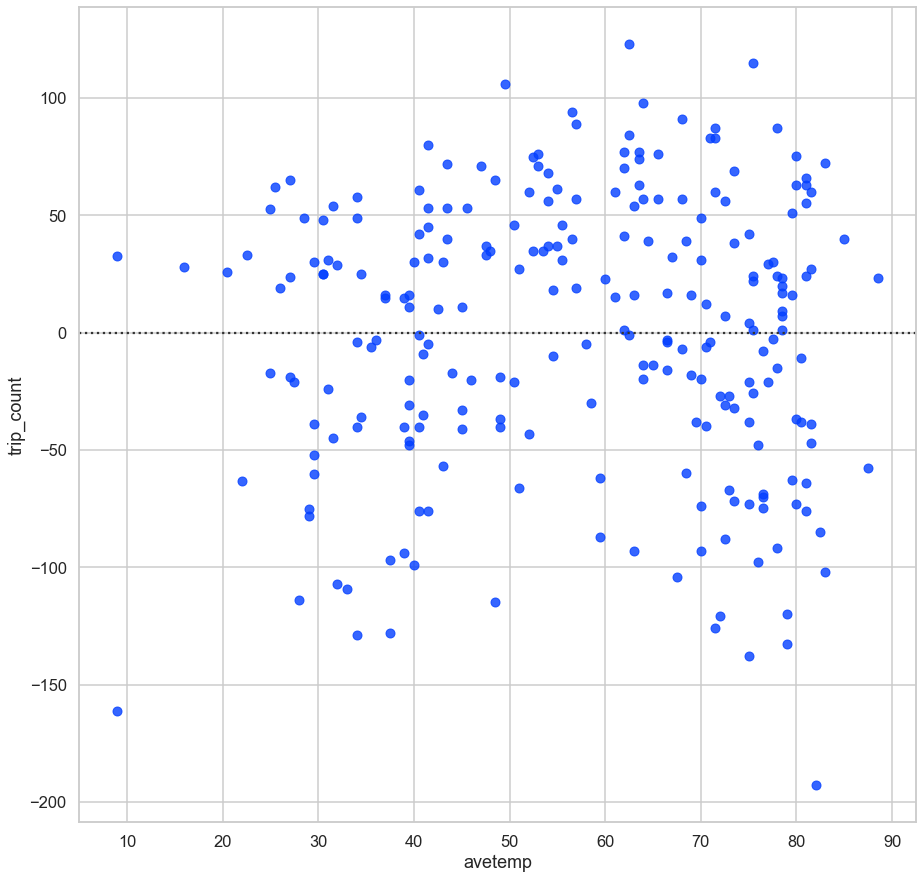

In [21]:
plt.figure(figsize=(15,15))
sns.residplot(trip_count_weather_by_date_df["avetemp"],trip_count_weather_by_date_df["trip_count"])
plt.show()

This residual plot seems to be also random. This is expected due to the relationship between average and maximum temperature. The linear model is suitable for this data.

In [22]:
# DO YOUR MAGIC WITH THE AIC THING

# How is Taxi Ridership Correlated with Time of Day?

In [23]:
scaled_daily_df = pd.concat([df]*round(1/0.002/242))
scaled_daily_df

,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,RatecodeID,congestion_surcharge,extra,fare_amount,improvement_surcharge,mta_tax,...,date,maxtemp,mintemp,avetemp,departuretemp,hdd,cdd,precipitation,newsnow,snowdepth
0,2019-01-17 18:30:40,2019-01-17 18:35:20,162,233,1.0,0.0,1.0,5.0,0.3,0.5,...,2019-01-17,33.0,24.0,28.5,-3.7,36.0,0.0,0.00,0.0,0.0
1,2019-01-07 20:45:41,2019-01-07 21:10:25,186,75,1.0,0.0,0.5,19.5,0.3,0.5,...,2019-01-07,34.0,25.0,29.5,-3.2,35.0,0.0,0.00,0.0,0.0
2,2019-01-29 10:00:49,2019-01-29 10:07:37,236,237,1.0,0.0,0.0,6.0,0.3,0.5,...,2019-01-29,43.0,25.0,34.0,1.1,31.0,0.0,0.23,0.0,0.0
3,2019-01-10 05:54:57,2019-01-10 06:12:44,211,138,1.0,0.0,0.5,29.0,0.3,0.5,...,2019-01-10,34.0,28.0,31.0,-1.4,34.0,0.0,0.00,0.0,0.0
4,2019-01-24 08:59:00,2019-01-24 09:12:27,233,170,1.0,0.0,0.0,9.0,0.3,0.5,...,2019-01-24,59.0,35.0,47.0,14.5,18.0,0.0,1.33,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112475,2019-08-06 13:51:50,2019-08-06 13:58:00,152,152,1.0,0.0,0.0,5.5,0.3,0.5,...,2019-08-06,79.0,71.0,75.0,-1.3,0.0,10.0,0.04,0.0,0.0
112476,2019-08-09 21:52:07,2019-08-09 22:07:06,113,230,1.0,2.5,0.5,11.0,0.3,0.5,...,2019-08-09,83.0,68.0,75.5,-0.6,0.0,11.0,0.08,0.0,0.0
112477,2019-08-01 11:00:06,2019-08-01 11:43:22,138,233,1.0,2.5,0.0,38.5,0.3,0.5,...,2019-08-01,87.0,70.0,78.5,2.0,0.0,14.0,0.00,0.0,0.0
112478,2019-08-18 14:53:39,2019-08-18 14:59:54,141,162,1.0,2.5,0.0,6.0,0.3,0.5,...,2019-08-18,90.0,70.0,80.0,4.8,0.0,15.0,0.64,0.0,0.0


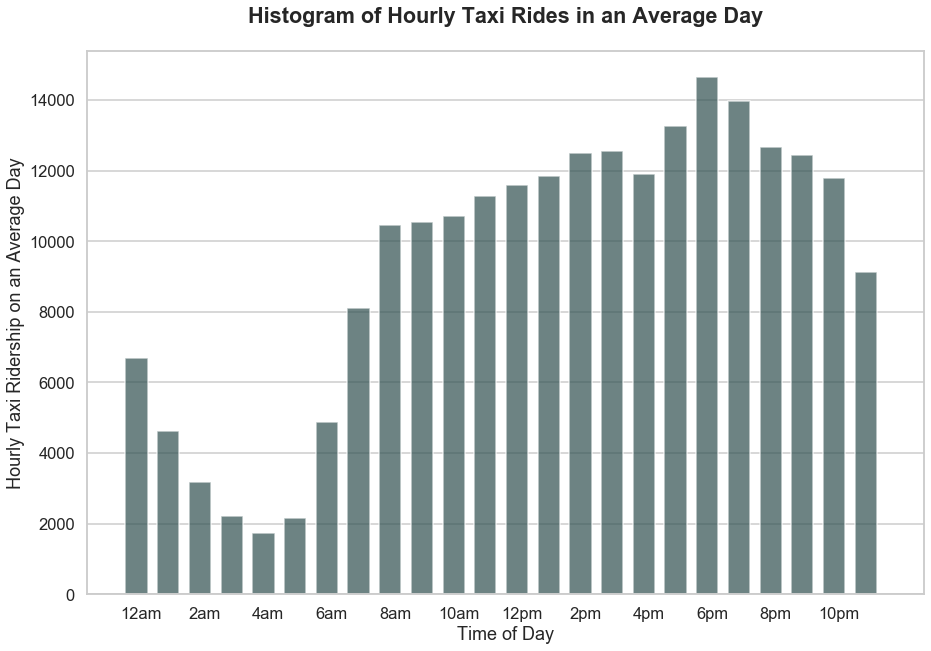

In [24]:
plt.figure(figsize=(15,10))
g=sns.distplot(pd.to_datetime(scaled_daily_df['pickup_datetime']).dt.hour, bins=np.arange(0,25,1)-0.5, kde=False, hist_kws={"width":0.7, "color":"darkslategray", 'alpha': 0.7})
g.xaxis.grid(b=False)
plt.xticks(np.arange(0,26, 2), labels=["12am","2am","4am","6am","8am","10am","12pm","2pm","4pm","6pm","8pm","10pm"])
plt.xlabel("Time of Day")
plt.ylabel("Hourly Taxi Ridership on an Average Day")
plt.title("Histogram of Hourly Taxi Rides in an Average Day", fontweight="bold", fontsize="large", y=1.04)
plt.show()

Taxi ridership is lowest in the early morning and peaks at 6pm in an average day. 

In [25]:
isweekend_df=scaled_daily_df.copy()
isweekend_df["isweekend"]=isweekend_df["pickup_dayofweek"].isin([5,6])
isweekend_df[["pickup_dayofweek","isweekend"]]

,pickup_dayofweek,isweekend
0,3,False
1,0,False
2,1,False
3,3,False
4,3,False
...,...,...
112475,1,False
112476,4,False
112477,3,False
112478,6,True


In [26]:
isweekend_y_df=isweekend_df[isweekend_df["isweekend"]==True]
isweekend_n_df=isweekend_df[isweekend_df["isweekend"]==False]

# accounting for how isweekend_df["isweekend"]==True occurs 2/7 of the time
scaled_isweekend_y_df = pd.concat([isweekend_y_df]*5)
scaled_isweekend_n_df = pd.concat([isweekend_n_df]*2)

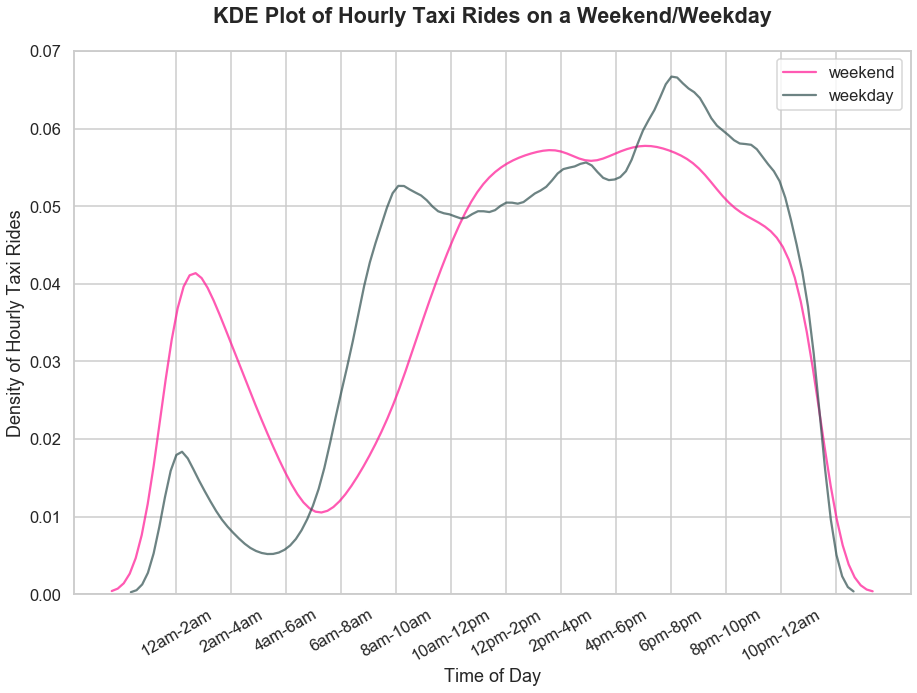

In [27]:
# f, axes = plt.subplots(1, 2, figsize=(20, 20), sharex=True)
plt.figure(figsize=(15,10))
sns.distplot(pd.to_datetime(isweekend_y_df['pickup_datetime']).dt.hour, bins=np.arange(0,25,2)-0.5, hist=False, label="weekend", kde_kws={"color":"deeppink", 'alpha': 0.7})
sns.distplot(pd.to_datetime(isweekend_n_df['pickup_datetime']).dt.hour, bins=np.arange(0,25,2)-0.5, hist=False,  label="weekday", kde_kws={"color":"darkslategray", 'alpha': 0.7})
plt.xticks(np.arange(0,25,2), labels=["12am-2am","2am-4am","4am-6am","6am-8am","8am-10am","10am-12pm","12pm-2pm","2pm-4pm","4pm-6pm","6pm-8pm","8pm-10pm","10pm-12am"], rotation=30)
plt.xlabel("Time of Day")
plt.ylabel("Density of Hourly Taxi Rides")
plt.legend()
plt.title("KDE Plot of Hourly Taxi Rides on a Weekend/Weekday", fontweight="bold", fontsize="large", y=1.04)
plt.show()


On weekends, a higher fraction of taxi rides occur in the early hours of the morning (12-4am), perhaps due to the crowd returning from parties. On weekdays, a higher fraction of rides occur in the mid-morning (8-10am) and early evening (6-8pm) as people commute to and from work. 

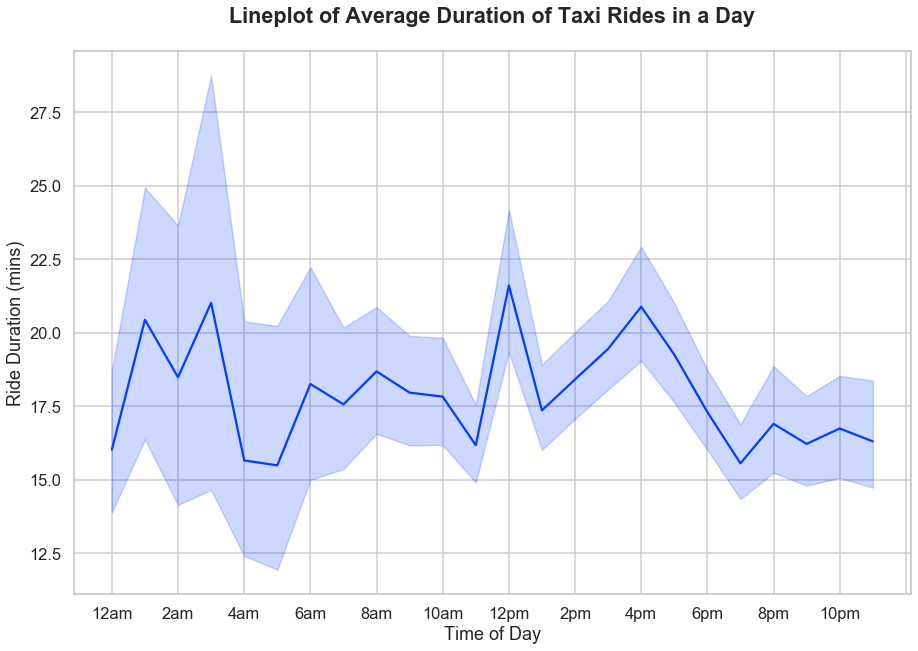

In [28]:
plt.figure(figsize=(15,10))
g=sns.lineplot(pd.to_datetime(df['pickup_datetime']).dt.hour, df["trip_duration_mins"])
plt.xticks(np.arange(0,26, 2), labels=["12am","2am","4am","6am","8am","10am","12pm","2pm","4pm","6pm","8pm","10pm"])
plt.xlabel("Time of Day")
plt.ylabel("Ride Duration (mins)")
plt.title("Lineplot of Average Duration of Taxi Rides in a Day", fontweight="bold", fontsize="large", y=1.04)
plt.show()

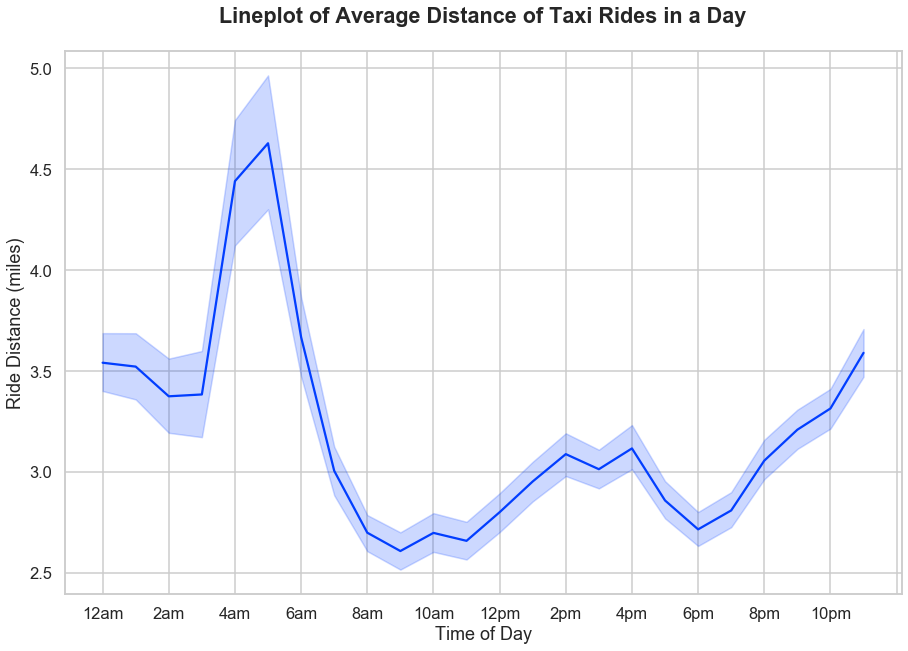

In [29]:
plt.figure(figsize=(15,10))
g=sns.lineplot(pd.to_datetime(df['pickup_datetime']).dt.hour, df["trip_distance"])
plt.xticks(np.arange(0,26, 2), labels=["12am","2am","4am","6am","8am","10am","12pm","2pm","4pm","6pm","8pm","10pm"])
plt.xlabel("Time of Day")
plt.ylabel("Ride Distance (miles)")
plt.title("Lineplot of Average Distance of Taxi Rides in a Day", fontweight="bold", fontsize="large", y=1.04)
plt.show()

In [30]:
df[df["trip_duration_mins"]==0]["trip_distance"]

32964     0.60
101724    0.01
109086    0.50
Name: trip_distance, dtype: float64

In [31]:
positive_trip_duration_df=df[df["trip_duration_mins"]>0]

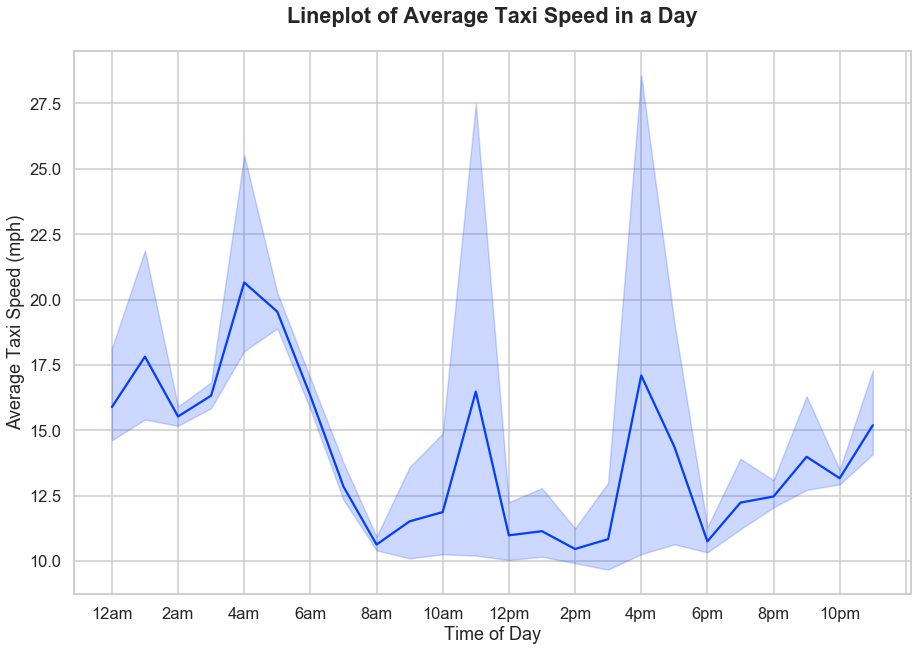

In [32]:
plt.figure(figsize=(15,10))
g=sns.lineplot(pd.to_datetime(positive_trip_duration_df['pickup_datetime']).dt.hour, positive_trip_duration_df["trip_distance"]/(positive_trip_duration_df["trip_duration_mins"]/60))
plt.xticks(np.arange(0,26, 2), labels=["12am","2am","4am","6am","8am","10am","12pm","2pm","4pm","6pm","8pm","10pm"])
plt.xlabel("Time of Day")
plt.ylabel("Average Taxi Speed (mph)")
plt.title("Lineplot of Average Taxi Speed in a Day", fontweight="bold", fontsize="large", y=1.04)
plt.show()

Average taxi speed is much higher in the early morning hours (around 4am). Therefore, even though these early-morning trips tend to be longer in distance, they last about the same duration as shorter-distance (but much slower) taxi trips around noon. 

In [33]:
isweekend_df=positive_trip_duration_df.copy()
isweekend_df["isweekend"]=isweekend_df["pickup_dayofweek"].isin([5,6])
isweekend_df['isweekend'] = isweekend_df['isweekend'].map({False: 'weekday', True: 'weekend'})
isweekend_df[["pickup_dayofweek","isweekend"]]

,pickup_dayofweek,isweekend
0,3,weekday
1,0,weekday
2,1,weekday
3,3,weekday
4,3,weekday
...,...,...
112475,1,weekday
112476,4,weekday
112477,3,weekday
112478,6,weekend


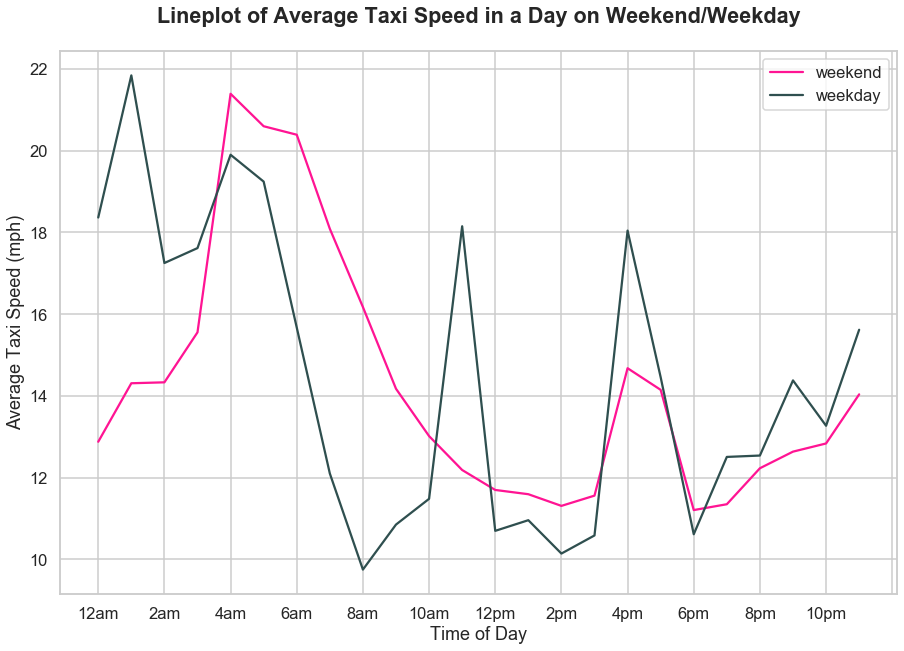

In [34]:
fig, ax = plt.subplots(figsize=(15,10))
sns.lineplot(pd.to_datetime(isweekend_df['pickup_datetime']).dt.hour, isweekend_df["trip_distance"]/(isweekend_df["trip_duration_mins"]/60), hue=isweekend_df["isweekend"], hue_order=["weekend","weekday"], err_style=None, palette=sns.color_palette(palette = ["deeppink", "darkslategray"]))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
plt.xticks(np.arange(0,26, 2), labels=["12am","2am","4am","6am","8am","10am","12pm","2pm","4pm","6pm","8pm","10pm"])
plt.xlabel("Time of Day")
plt.ylabel("Average Taxi Speed (mph)")
plt.title("Lineplot of Average Taxi Speed in a Day on Weekend/Weekday", fontweight="bold", fontsize="large", y=1.04)
plt.show()

END OF SECTION: CONSIDER RESHUFFLING/PUTTING BEFORE LINEAR REGRESSION MODEL

# 4. Zooming into Manhattan: What Variables are Useful to Predict the Odds of a Downtown/Non-Downtown Ride?

## 4.1 Laying the Foundations

Now, we will dive into the question of which variables can help us predict the odds of a Manhattan taxi ride having a downtown pickup/dropoff location. For this part, we will create several new variables:
- `is_downtown`: a binary variable that codes whether a ride has a downtown pickup/dropoff location *(1: yes, 0: no)*


- `PUtime_of_day`: a variable that describes the time of day of a ride pickup *(early morning: 3am-7am, morning rush hour: 7am-11am, lunchtime: 11am-3pm, evening rush hour: 3pm-7pm, late evening: 7pm-11pm, late night: 11pm-3am)*


- `DOtime_of_day`: a variable that describes the time of day of a ride dropoff *(early morning: 3am-7am, morning rush hour: 7am-11am, lunchtime: 11am-3pm, evening rush hour: 3pm-7pm, late evening: 7pm-11pm, late night: 11pm-3am)*


- 6 dummy variables for pickup time of day (`pickup_early_morning`, `pickup_morning_rush_hour`, `pickup_lunchtime`, `pickup_evening_rush_hour`,`pickup_late_evening` and `pickup_late_night`)


- 6 dummy variables for pickup time of day (`dropoff_early_morning`, `dropoff_morning_rush_hour`, `dropoff_lunchtime`, `dropoff_evening_rush_hour`,`dropoff_late_evening` and `dropoff_late_night`)

Before we start, we will import the taxi zone lookup table (adapted from https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv). This table maps pickup/dropoff location IDs to named locations in Manhattan, which we classified into 4 zones:

- Uptown: above 59th Street


- Midtown: 34th-59th Street


- Lower-Midtown: 14th-33rd Street


- Downtown: below 14th Street


We will also create a new dataframe with Manhattan-only rides and perform some data manipulation to ready it for logistic regression. 

In [35]:
#importing taxi zone lookup dataset that has been preprocessed and tagged with Manhattan zones (Uptown, Midtown, Lower-Midtown, Downtown)
taxi_zone_lookup_df = pd.read_csv("taxi_zone_lookup.csv")

#merging is_weekend_df with taxi_zone_lookup_df
lagg_df=isweekend_df.merge(taxi_zone_lookup_df,how="left",left_on=isweekend_df["PULocationID"], right_on=taxi_zone_lookup_df["LocationID"])
lagg_df.rename(columns={"Borough":"PUborough","Zone":"PUzone","service_zone":"PUservice_zone","manhattan_zone":"PUmanhattan_zone"},inplace=True)
lagg_df.drop(columns=["key_0","LocationID"],inplace=True)
lagg_df=lagg_df.merge(taxi_zone_lookup_df,how="left",left_on=lagg_df["DOLocationID"], right_on=taxi_zone_lookup_df["LocationID"])
lagg_df.rename(columns={"Borough":"DOborough","Zone":"DOzone","service_zone":"DOservice_zone","manhattan_zone":"DOmanhattan_zone"},inplace=True)
lagg_df.drop(columns=["key_0","LocationID"],inplace=True)
lagg_df.replace({"isweekend": {"weekday":0,"weekend":1}}, inplace=True)
# lagg_df.head()

#categorizing time of day into 6 names (early morning, morning rush hour, lunchtime, evening rush hour, late evening, late night)
lagg_df["PUtime_of_day"]=pd.to_datetime(lagg_df['pickup_datetime']).dt.hour
lagg_df.replace({"PUtime_of_day": {3:"early morning",4:"early morning",5:"early morning",6:"early morning",7:"morning rush hour",8:"morning rush hour",9:"morning rush hour",10:"morning rush hour",11:"lunchtime",12:"lunchtime",13:"lunchtime",14:"lunchtime",15:"evening rush hour",16:"evening rush hour",17:"evening rush hour",18:"evening rush hour",19:"late evening",20:"late evening",21:"late evening",22:"late evening", 23:"late night",0:"late night",1:"late night",2:"late night"}}, inplace=True)
lagg_df["DOtime_of_day"]=pd.to_datetime(lagg_df['dropoff_datetime']).dt.hour
lagg_df.replace({"DOtime_of_day": {3:"early morning",4:"early morning",5:"early morning",6:"early morning",7:"morning rush hour",8:"morning rush hour",9:"morning rush hour",10:"morning rush hour",11:"lunchtime",12:"lunchtime",13:"lunchtime",14:"lunchtime",15:"evening rush hour",16:"evening rush hour",17:"evening rush hour",18:"evening rush hour",19:"late evening",20:"late evening",21:"late evening",22:"late evening", 23:"late night",0:"late night",1:"late night",2:"late night"}}, inplace=True)

#removing taxi rides with no charge or disputed taxi fares
lagg_df = lagg_df.query("(payment_type!=3.0) & (payment_type!=4.0)")
lagg_df = lagg_df.astype({"payment_type":"int32"})

#creating two datasets: one for taxi rides with Manhattan pickups and the other for taxi rides with Manhattan dropoffs
pu_manhattan_df=lagg_df[~pd.isnull(lagg_df["PUmanhattan_zone"])]
do_manhattan_df=lagg_df[~pd.isnull(lagg_df["DOmanhattan_zone"])]

#creating a larger dataset for taxi rides with Manhattan pickups or dropoffs
manhattan_df=lagg_df[~pd.isnull(lagg_df["PUmanhattan_zone"])|~pd.isnull(lagg_df["DOmanhattan_zone"])]

#splitting manhattan_df into two datasets based on whether a ride had downtown pickups/dropoffs
PUDO_downtown_y_df=manhattan_df[(manhattan_df["PUmanhattan_zone"]=="Downtown") | (manhattan_df["DOmanhattan_zone"]=="Downtown")]
PUDO_downtown_n_df=manhattan_df[(manhattan_df["PUmanhattan_zone"]!="Downtown") & (manhattan_df["DOmanhattan_zone"]!="Downtown")]

#creating an is_downtown column to code downtown/non-downtown rides
manhattan_df["is_downtown"]=np.where((manhattan_df["PUmanhattan_zone"]=="Downtown") | (manhattan_df["DOmanhattan_zone"]=="Downtown"),1,0)

#replacing PUtime_of_day with 6 columns of dummy variables
PUtimeofday_dummies=pd.get_dummies(manhattan_df["PUtime_of_day"])
manhattan_df=manhattan_df.join(PUtimeofday_dummies)
manhattan_df.rename(columns={"early morning":"pickup_early_morning", "morning rush hour":"pickup_morning_rush_hour", "lunchtime":"pickup_lunchtime", "evening rush hour":"pickup_evening_rush_hour", "late evening":"pickup_late_evening", "late night":"pickup_late_night"}, inplace=True)

#replacing DOtime_of_day with 6 columns of dummy variables
DOtimeofday_dummies=pd.get_dummies(manhattan_df["DOtime_of_day"])
manhattan_df=manhattan_df.join(DOtimeofday_dummies)
manhattan_df.rename(columns={"early morning":"dropoff_early_morning", "morning rush hour":"dropoff_morning_rush_hour", "lunchtime":"dropoff_lunchtime", "evening rush hour":"dropoff_evening_rush_hour", "late evening":"dropoff_late_evening", "late night":"dropoff_late_night"}, inplace=True)
manhattan_df.drop(columns=["PUtime_of_day","DOtime_of_day"], inplace=True)

/Users/josiah/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [36]:
manhattan_df["pickup_dropoff_early_morning"]=np.where((manhattan_df["pickup_early_morning"]==1) | (manhattan_df["dropoff_early_morning"]==1),1,0)
manhattan_df["pickup_dropoff_morning_rush_hour"]=np.where((manhattan_df["pickup_morning_rush_hour"]==1) | (manhattan_df["dropoff_morning_rush_hour"]==1),1,0)
manhattan_df["pickup_dropoff_lunchtime"]=np.where((manhattan_df["pickup_lunchtime"]==1) | (manhattan_df["dropoff_lunchtime"]==1),1,0)
manhattan_df["pickup_dropoff_evening_rush_hour"]=np.where((manhattan_df["pickup_evening_rush_hour"]==1) | (manhattan_df["dropoff_evening_rush_hour"]==1),1,0)
manhattan_df["pickup_dropoff_late_evening"]=np.where((manhattan_df["pickup_late_evening"]==1) | (manhattan_df["dropoff_late_evening"]==1),1,0)
manhattan_df["pickup_dropoff_late_night"]=np.where((manhattan_df["pickup_late_night"]==1) | (manhattan_df["dropoff_late_night"]==1),1,0)

## 4.2 Examining Correlations with `is_downtown` through Visualizations

As a first step, we will run a correlation heatmap to identify the explanatory variables with noticeable correlations with our response variable (`is_downtown`). 

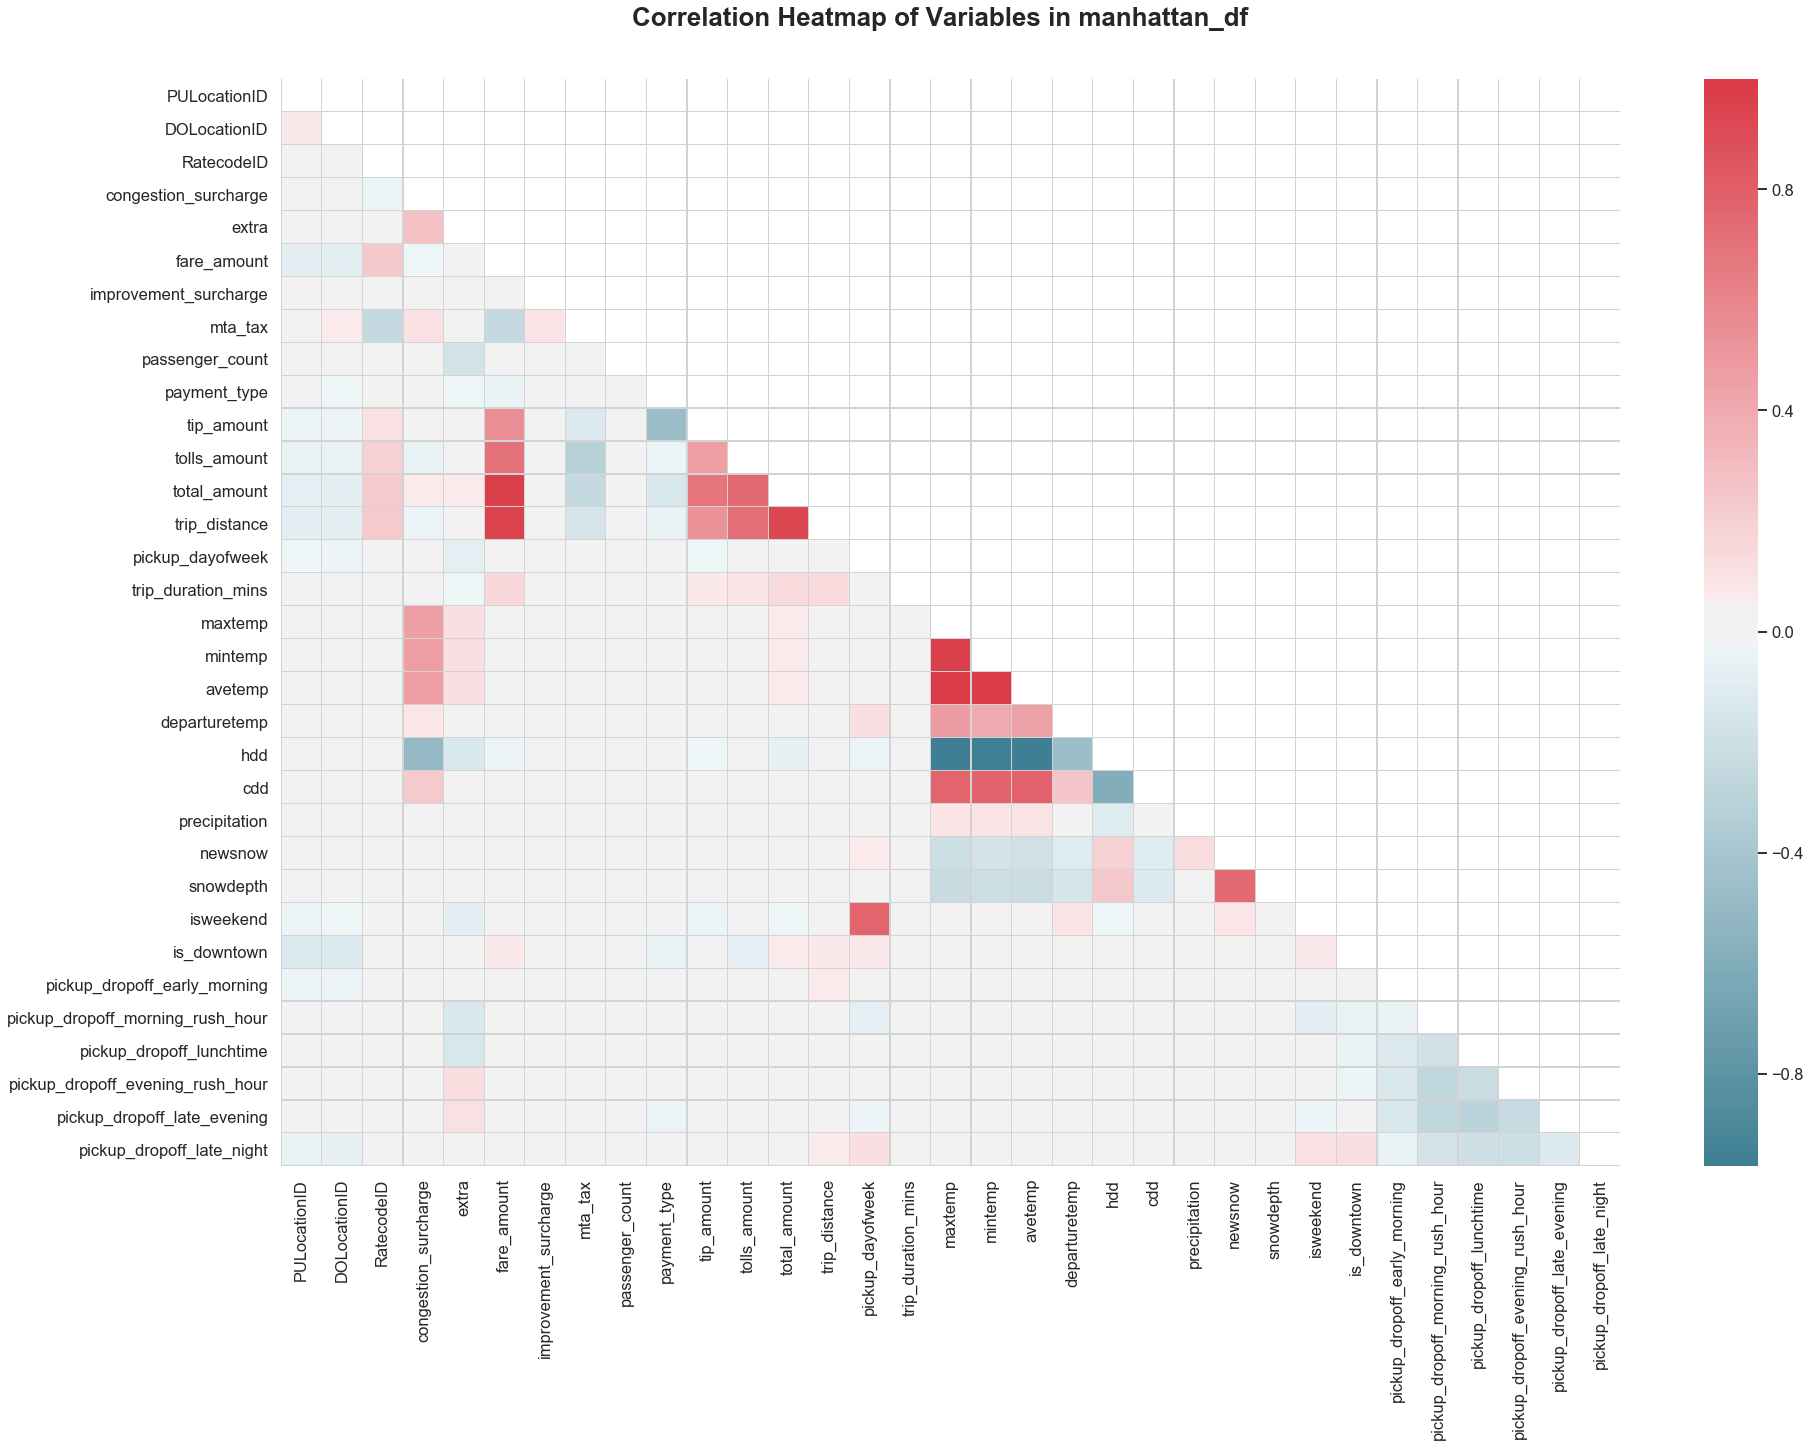

In [37]:
corr=manhattan_df.drop(columns=["pickup_early_morning","pickup_morning_rush_hour","pickup_lunchtime","pickup_evening_rush_hour","pickup_late_evening","pickup_late_night","dropoff_early_morning","dropoff_morning_rush_hour","dropoff_lunchtime","dropoff_evening_rush_hour","dropoff_late_evening","dropoff_late_night"]).corr()
plt.figure(figsize=(30,20))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax=sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True),  mask = mask, linewidths=0.2, linecolor='lightgray')

#fix for seaborn bug where top and bottom boxes are cut off (adapted from https://github.com/mwaskom/seaborn/issues/1773)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)
plt.suptitle("Correlation Heatmap of Variables in manhattan_df", fontweight="bold", fontsize="x-large", x=0.43, y=0.93)
plt.show()

Looking on this heatmap, explanatory variables correlated with `is_downtown` include:
- Whether the taxi ride occurred on a weekend (`isweekend`) 
- Time of day (especially `pickup_dropoff_morning_rush_hour`, `pickup_dropoff_lunchtime`, `pickup_dropoff_evening_rush_hour` and `pickup_dropoff_late_night`)
- Amount of payment (`fare_amount`,`tip_amount` and `total_amount`)
- Distance logged in a taxi ride (`trip_distance`)
- Payment type (`payment_type`)

We will proceed with some visualizations to better understand the strength and direction of the relationship between these explanatory variables and `is_downtown`. 

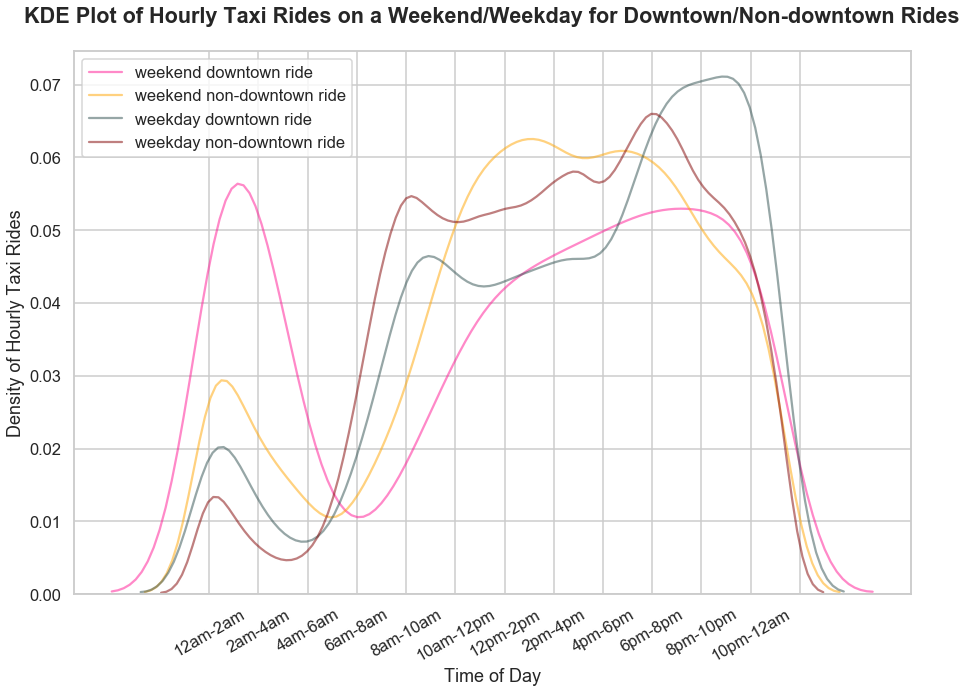

In [38]:
plt.figure(figsize=(15,10))
sns.distplot(pd.to_datetime(manhattan_df[(manhattan_df["isweekend"]==1) & (manhattan_df["is_downtown"]==1)]['pickup_datetime']).dt.hour, bins=np.arange(0,25,2)-0.5, hist=False, label="weekend downtown ride", kde_kws={"color":"deeppink", 'alpha': 0.5})
sns.distplot(pd.to_datetime(manhattan_df[(manhattan_df["isweekend"]==1) & (manhattan_df["is_downtown"]==0)]['pickup_datetime']).dt.hour, bins=np.arange(0,25,2)-0.5, hist=False, label="weekend non-downtown ride", kde_kws={"color":"orange", 'alpha': 0.5})
sns.distplot(pd.to_datetime(manhattan_df[(manhattan_df["isweekend"]==0) & (manhattan_df["is_downtown"]==1)]['pickup_datetime']).dt.hour, bins=np.arange(0,25,2)-0.5, hist=False, label="weekday downtown ride", kde_kws={"color":"darkslategray", 'alpha': 0.5})
sns.distplot(pd.to_datetime(manhattan_df[(manhattan_df["isweekend"]==0) & (manhattan_df["is_downtown"]==0)]['pickup_datetime']).dt.hour, bins=np.arange(0,25,2)-0.5, hist=False, label="weekday non-downtown ride", kde_kws={"color":"maroon", 'alpha': 0.5})
plt.xticks(np.arange(0,25,2), labels=["12am-2am","2am-4am","4am-6am","6am-8am","8am-10am","10am-12pm","12pm-2pm","2pm-4pm","4pm-6pm","6pm-8pm","8pm-10pm","10pm-12am"], rotation=30)
plt.xlabel("Time of Day")
plt.ylabel("Density of Hourly Taxi Rides")
plt.title("KDE Plot of Hourly Taxi Rides on a Weekend/Weekday for Downtown/Non-downtown Rides", fontweight="bold", fontsize="large", y=1.04)
plt.show()

Using a KDE plot, we discover the following: 
- On late nights (11pm-3am), the density of weekend downtown rides is much higher than that of weekday downtown rides, thus conforming with the correlation heatmap's results. It also makes sense as many late-night parties occur in the downtown area on weekends, drawing more taxi rides to and from downtown on weekends.


- On early mornings (3am-7am), the density of weekend downtown rides is higher than that of weekday downtown rides from 3-5am but dips below the gray line from 5-7am. the "canceling out" of opposite effects may explain why the correlation betwen early mornings and `is_downtown` is negligible. 


- On late evenings (7pm-11pm), the density of downtown rides (gray and pink lines) is generally higher than that of non-downtown rides (represented by brown and yellow lines). This suggests that the late evening time window might be a good variable to use to predict `is_downtown` odds. 

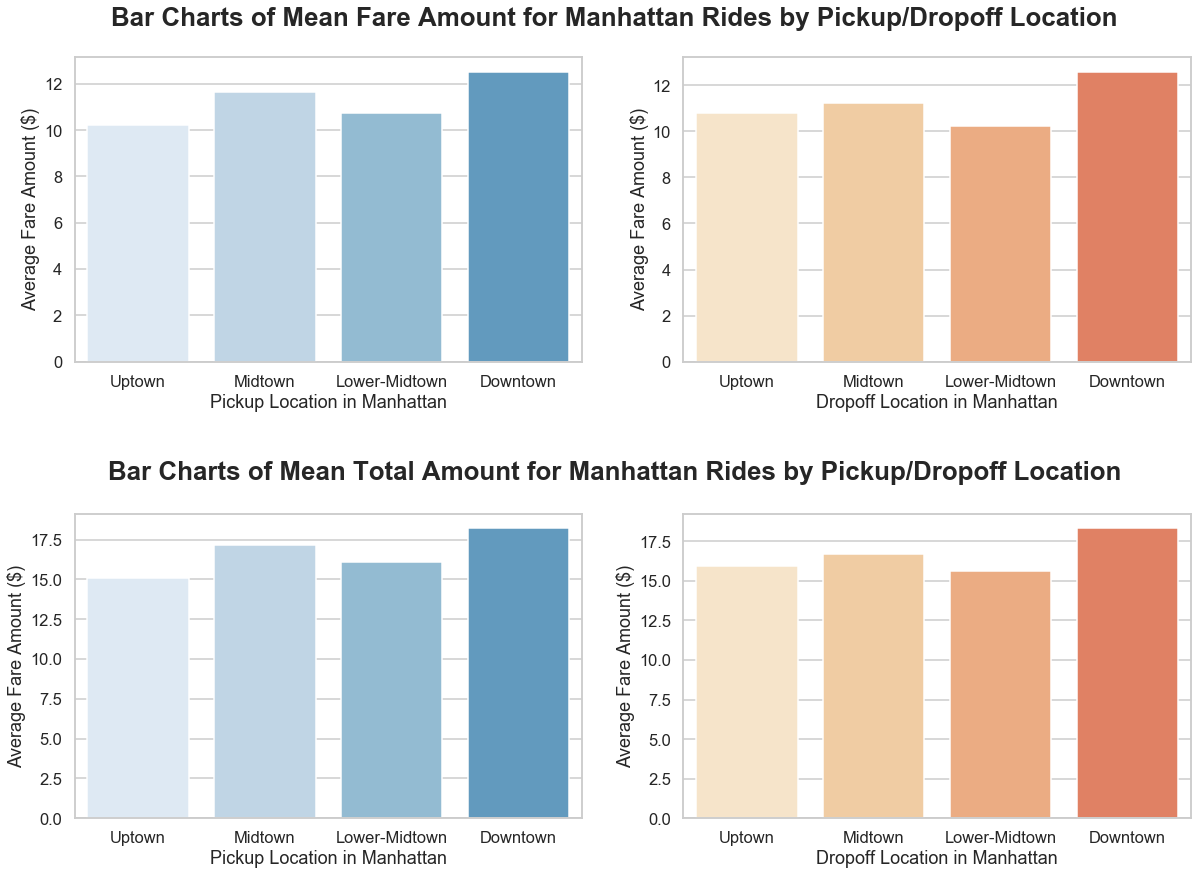

In [39]:
fig,axes=plt.subplots(2,2, figsize=(20,14))

sns.barplot(pu_manhattan_df["PUmanhattan_zone"], pu_manhattan_df["fare_amount"], order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[0,0], palette=sns.color_palette("Blues")).set(ylabel='Average Fare Amount ($)', xlabel="Pickup Location in Manhattan")
sns.barplot(do_manhattan_df["DOmanhattan_zone"], do_manhattan_df["fare_amount"], order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[0,1],  palette=sns.color_palette("OrRd")).set(ylabel='Average Fare Amount ($)', xlabel="Dropoff Location in Manhattan")

sns.barplot(pu_manhattan_df["PUmanhattan_zone"], pu_manhattan_df["total_amount"], order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[1,0], palette=sns.color_palette("Blues")).set(ylabel='Average Fare Amount ($)', xlabel="Pickup Location in Manhattan")
sns.barplot(do_manhattan_df["DOmanhattan_zone"], do_manhattan_df["total_amount"], order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[1,1],  palette=sns.color_palette("OrRd")).set(ylabel='Average Fare Amount ($)', xlabel="Dropoff Location in Manhattan")

plt.figtext(0.5,0.93, "Bar Charts of Mean Fare Amount for Manhattan Rides by Pickup/Dropoff Location", ha="center", va="top", fontsize="x-large", fontweight="bold")
plt.figtext(0.5,0.48, "Bar Charts of Mean Total Amount for Manhattan Rides by Pickup/Dropoff Location", ha="center", va="top", fontsize="x-large", fontweight="bold")
plt.subplots_adjust(hspace = 0.5 )

plt.show()

The bar charts above show that for both taxi pickups and dropoffs, the mean fare amount is significantly higher for the downtown area than the non-downtown area, thus echoing the positive correlation between `is_downtown` and `fare_amount`. The mean total amount (which includes fare amount, tip amount and tolls) is similarly higher for downtown rides than non-downtown rides. 

What is the intuition behind this? Fare amount is a influenced by both trip distance (\\$0.50 per 1/5 mile above 12mph) and trip duration (\\$0.50 per 60 seconds in slow traffic). Do downtown trips tend to clock a longer distance, or do they simply take a longer time traversing the same distance (have a lower speed)?

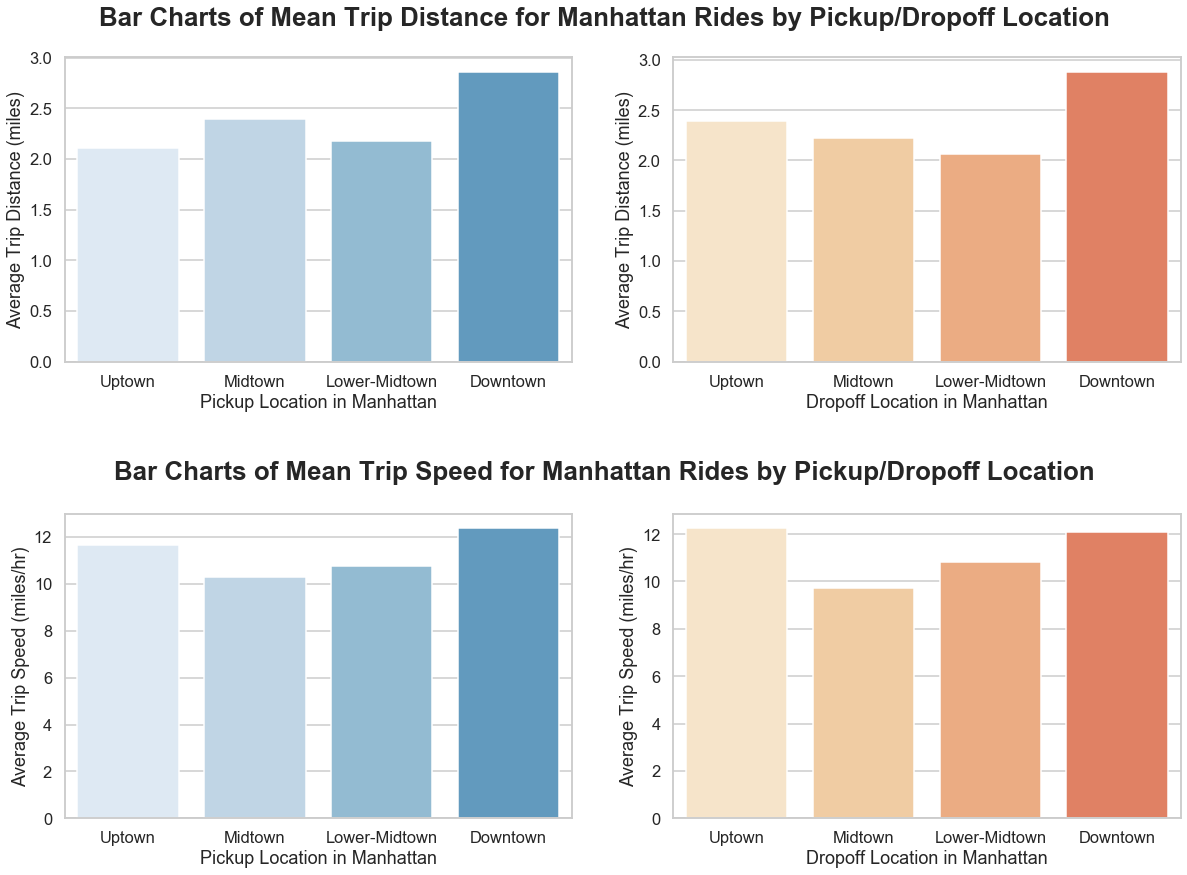

In [40]:
fig,axes=plt.subplots(2,2, figsize=(20,14))

sns.barplot(pu_manhattan_df["PUmanhattan_zone"], pu_manhattan_df["trip_distance"], order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[0,0], palette=sns.color_palette("Blues")).set(ylabel='Average Trip Distance (miles)', xlabel="Pickup Location in Manhattan")
sns.barplot(do_manhattan_df["DOmanhattan_zone"], do_manhattan_df["trip_distance"], order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[0,1],  palette=sns.color_palette("OrRd")).set(ylabel='Average Trip Distance (miles)', xlabel="Dropoff Location in Manhattan")

sns.barplot(pu_manhattan_df["PUmanhattan_zone"], pu_manhattan_df["trip_distance"]/pu_manhattan_df["trip_duration_mins"]*60, order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[1,0], palette=sns.color_palette("Blues")).set(ylabel='Average Trip Speed (miles/hr)', xlabel="Pickup Location in Manhattan")
sns.barplot(do_manhattan_df["DOmanhattan_zone"], do_manhattan_df["trip_distance"]/do_manhattan_df["trip_duration_mins"]*60, order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[1,1],  palette=sns.color_palette("OrRd")).set(ylabel='Average Trip Speed (miles/hr)', xlabel="Dropoff Location in Manhattan")

plt.figtext(0.5,0.93, "Bar Charts of Mean Trip Distance for Manhattan Rides by Pickup/Dropoff Location", ha="center", va="top", fontsize="x-large", fontweight="bold")
plt.figtext(0.5,0.48, "Bar Charts of Mean Trip Speed for Manhattan Rides by Pickup/Dropoff Location", ha="center", va="top", fontsize="x-large", fontweight="bold")
plt.subplots_adjust(hspace = 0.5 )

plt.show()

It turns out that trip distance is the main factor at play for the difference in fare amounts between downtown and non-downtown trips. For downtown rides, the mean trip distance is more than half a mile longer than the mean trips distances of uptown, midtown and lower-midtown rides. This could be due to the heavy reliance of taxis among employees in the downtown financial services industry to commute to and from home (in other Manhattan zones or NYC boroughs). 

The mean speed for downtown rides is actually greater than or equal to the mean speed of non-downtown rides, suggesting that "duration in slow traffic" component in taxi fares is in fact lower for downtown rides. 

## 4.3 Logistic Regression

### 4.3.1 Building of model

Like what we did for the linear regression model in Section 3.4, we will use the Akaike’s Information Criterion (AIC) to select a logistic regression model with the best relative quality&mdash;the best balance between goodness of fit and complexity. If our interpretations were accurate in Section 4.2, the mix of variables that yield the lowest AIC should largely be the same as those we identified. 

In [41]:
Xcols=["fare_amount", "total_amount", "tip_amount", "tolls_amount","payment_type", "trip_duration_mins", "trip_distance", "passenger_count", "isweekend", "precipitation", "pickup_dropoff_early_morning", "pickup_dropoff_morning_rush_hour", "pickup_dropoff_evening_rush_hour", "pickup_dropoff_late_evening", "pickup_dropoff_late_night"]

def minAIC(X,y):
    variables = X.columns
    model = sm.Logit(y,X[variables]).fit()
    while True:
        print(f'Old model AIC: {model.aic}')
        maxp = np.max(model.pvalues)
        newvariables = variables[model.pvalues < maxp]
        newmodel = sm.Logit(y,X[newvariables]).fit()
        print(f'New model AIC: {newmodel.aic}')
        if newmodel.aic < model.aic:
            model = newmodel
            variables = newvariables
        else:
            break
    return model,variables

X=manhattan_df[Xcols]
X = sm.add_constant(X)
print(f"Initial Variables are {np.array(X.columns)}\n")
y=manhattan_df["is_downtown"]
new_model, logit_variables = minAIC(X, y)
new_model = sm.Logit(y, X[logit_variables]).fit()
print(f"After Optimization, New model AIC is {new_model.aic}\n")
print(f"After Optimization, New Variables are {np.array(new_model.params.index)}")

/Users/josiah/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Initial Variables are ['const' 'fare_amount' 'total_amount' 'tip_amount' 'tolls_amount'
 'payment_type' 'trip_duration_mins' 'trip_distance' 'passenger_count'
 'isweekend' 'precipitation' 'pickup_dropoff_early_morning'
 'pickup_dropoff_morning_rush_hour' 'pickup_dropoff_evening_rush_hour'
 'pickup_dropoff_late_evening' 'pickup_dropoff_late_night']

Optimization terminated successfully.
         Current function value: 0.531611
         Iterations 6
Old model AIC: 113090.81046571152
Optimization terminated successfully.
         Current function value: 0.531616
         Iterations 6
New model AIC: 113089.76263551052
Old model AIC: 113089.76263551052
Optimization terminated successfully.
         Current function value: 0.531629
         Iterations 6
New model AIC: 113090.62709867509
Optimization terminated successfully.
         Current function value: 0.531616
         Iterations 6
After Optimization, New model AIC is 113089.76263551052

After Optimization, New Variables are ['const' '

As expected, the variables with negligible correlation, namely `passenger_count`, `avetemp`, `maxtemp` and `trip_duration_mins`, fall out of the optimized model. 

However, there are some unexpected explanatory variables (with little correlation to `is_downtown` previously) added to the optimized model. These are `precipitation`, `tip_amount` and `trip_duration_mins`. 

The explanatory variables with a noticeable correlation to `is_downtown` previously have all been included in the optimized model. These factors are `fare_amount`, `total_amount`, `tip_amount`, `tolls_amount`, `payment_type`, `trip_distance`, `isweekend` and the time of day variables (`pickup_dropoff_early_morning`, `pickup_dropoff_morning_rush_hour`, `pickup_dropoff_evening_rush_hour`,`pickup_dropoff_late_evening` and `pickup_dropoff_late_night`). Notice that we excluded `pickup_dropoff_lunchtime` to avoid over-parameterizing the model. 

Next, we will proceed to interpret the coefficients of the logistic regression. 

In [42]:
results = new_model.summary()
results

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            is_downtown   No. Observations:               106336
Model:                          Logit   Df Residuals:                   106321
Method:                           MLE   Df Model:                           14
Date:                Tue, 12 May 2020   Pseudo R-squ.:                 0.05051
Time:                        09:35:04   Log-Likelihood:                -56530.
converged:                       True   LL-Null:                       -59537.
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               -1.7031      0.041    -41.419      0.000      -1.784      -1.623
fare_amount                         -0.0719      0.008     -9.100      0.000      -0.087      -0.056
total_amount                         0.0944      0.007     12.598      0.000       0.080       0.109
tip_amount                          -0.0854      0.009     -9.767      0.000      -0.103      -0.068
tolls_amount                        -0.5275      0.012    -43.285      0.000      -0.551      -0.504
payment_type                        -0.2749      0.020    -13.476      0.000      -0.315      -0.235
trip_duration_mins                   0.0002   9.96e-05      1.716      0.086   -2.42e-05       0.000
trip_distance                        0.0822      0.008     10.801      0.000       0.067       0.097
isweekend                            0.3353      0.016     20.381      0.000       0.303       0.368
precipitation                       -0.0697      0.024     -2.955      0.003      -0.116      -0.023
pickup_dropoff_early_morning         0.1200      0.036      3.338      0.001       0.050       0.190
pickup_dropoff_morning_rush_hour    -0.0824      0.024     -3.426      0.001      -0.130      -0.035
pickup_dropoff_evening_rush_hour    -0.0421      0.022     -1.947      0.052      -0.084       0.000
pickup_dropoff_late_evening          0.2606      0.021     12.659      0.000       0.220       0.301
pickup_dropoff_late_night            0.6248      0.024     25.524      0.000       0.577       0.673
====================================================================================================
"""

In [43]:
np.exp(new_model.params)

const                               0.182117
fare_amount                         0.930659
total_amount                        1.099015
tip_amount                          0.918165
tolls_amount                        0.590079
payment_type                        0.759625
trip_duration_mins                  1.000171
trip_distance                       1.085716
isweekend                           1.398356
precipitation                       0.932668
pickup_dropoff_early_morning        1.127473
pickup_dropoff_morning_rush_hour    0.920862
pickup_dropoff_evening_rush_hour    0.958817
pickup_dropoff_late_evening         1.297664
pickup_dropoff_late_night           1.867875
dtype: float64

Using a two-tailed z-test at a 5% significant level, we reject the null hypothesis that a variable's coefficient is 0 if its upper-tail p-value is below 0.025. `trip_duration_mins` and `pickup_dropoff_evening_rush_hour` are statistically insignificant as their p-values are 0.086 and 0.052 respectively (both above 0.025). 

Some noteworthy findings from the logistic regression model include:

- A late-night time (as indicated by `pickup_dropoff_late_night`) increases the odds of a ride originating/ending in downtown by 86.8%, while a late-evening time (as indicated by `pickup_dropoff_late_evening`) boosts those odds by 29.8%. Echoing earlier visualizations, a weekend pickup or dropoff (as indicated by `is_weekend`) increases those odds by 39.8%. 


- A 1-mile increase in `trip_distance` boosts the odds of a downtown ride by 8.6%. 


- Echoing a trend of greater preference for (and ability to afford) credit cards among downtown employees, the use of credit cards instead of cash, as indicated by a `payment_type` of 0 instead of 1, increases the odds of a downtown ride by 24%.


- Despite the positive correlation between `fare_amount` and the `is_downtown` in the correlation matrix, a \\$1 increase in fare amount leads to a 8.2\% decrease in the odds of a Manhattan ride having a downtown origin/destination. That being said, a \\$1 increase in `total_amount` is linked to a 9.9% increase in the odds of a downtown ride.



### 4.3.2 Evaluation of Model

We then train the logistic regression model on a training set and use it to predict `is_downtown` odds on a test set, with the goal of evaluating the model's classification ability.

In [44]:
logit_variables=list(logit_variables)
logit_variables.remove("const")
y=manhattan_df["is_downtown"]
X=manhattan_df[logit_variables]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
lgtmodel = LogisticRegression(solver = 'newton-cg').fit(X_train,y_train)

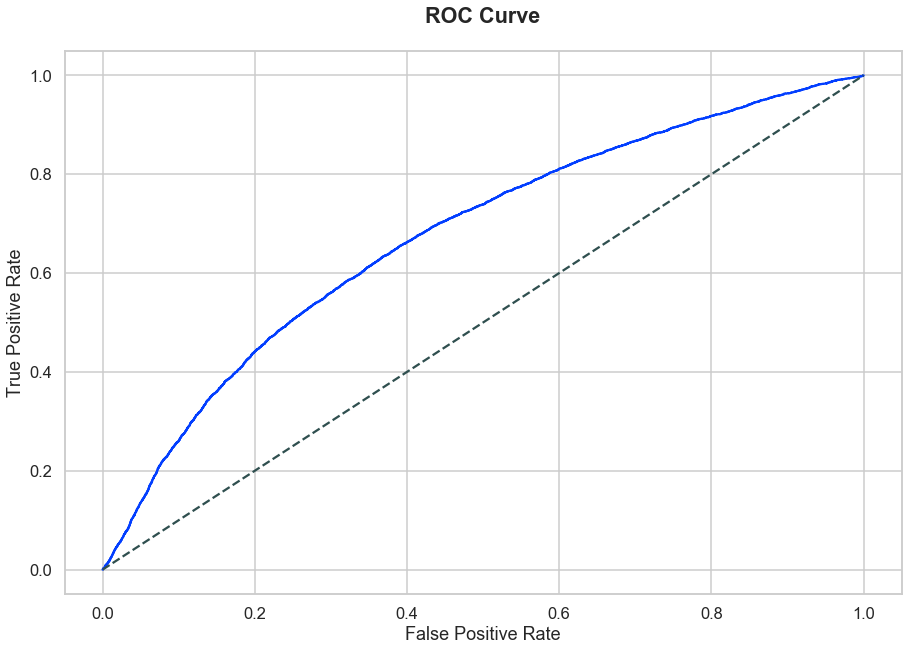

In [45]:
y_pred_probs = lgtmodel.predict_proba(X_test[logit_variables])[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

plt.figure(figsize=(15,10))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],color="darkslategray", linestyle="dashed")

plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve", fontweight="bold", fontsize="large", y=1.04)
plt.show()

The ROC curve above illustrates the diagnostic ability of our model at different discrimination thresholds. With the goal of maximizing the true positive rate while minimizing the false positive rate, we select a threshold that matches a false positive rate of 0.38 for our model. 

In [47]:
y_pred = lgtmodel.predict_proba(X_test)[:,1]>0.24
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(confusion_matrix(y_test, y_pred))

[[15164  8822]
 [ 2911  5004]]


Based on the confusion matrix above, our model has 5004 true positives, 8822 false positives, 15164 true negatives and 2911 false negatives. This yields a true positive rate of 63.2% and a false positive rate of 36.8%. In other words, our model predicts that `is_downtown` is true when it is actually true 63.2% of the time , and it mistakenly predicts that `is_downtown` is true when it is actually false 36.8% of the time. 

In [48]:
lgtscore=lgtmodel.score(X_test,y_test)
print(f"Mean Accuracy Score of Logistic Regression is {lgtscore}")

Mean Accuracy Score of Logistic Regression is 0.749036080373656


Our logistic regression model yields a mean accuracy score of 0.749, meaning that it classifies `is_downtown` values correctly 74.9% of the time. Can we make better predictions with other binary classifiers?

## 4.4 Other Binary Classifiers

The other binary classifiers we experiment with are K Nearest Neighbors, random forests, adaptive boosting (AdaBoost) and decision trees. 

In [49]:
knmodel = KNeighborsClassifier(60)
knmodel.fit(X_train,y_train)
knscore=knmodel.score(X_test,y_test)
print(f"Mean Accuracy Score of K Nearest Neighbors Classifier is {knscore}")

Mean Accuracy Score of K Nearest Neighbors Classifier is 0.7599761762954139


In [50]:
rfmodel = RandomForestClassifier(max_depth=5, n_estimators=5)
rfmodel.fit(X_train,y_train)
rfscore=rfmodel.score(X_test,y_test)
print(f"Mean Accuracy Score of Random Forest Classifier is {rfscore}")

Mean Accuracy Score of Random Forest Classifier is 0.7538321682705871


In [51]:
adbmodel = AdaBoostClassifier()
adbmodel.fit(X_train,y_train)
adbscore=adbmodel.score(X_test,y_test)
print(f"Mean Accuracy Score of Adaptive Boosting Classifier is {adbscore}")

Mean Accuracy Score of Adaptive Boosting Classifier is 0.7515438387511363


In [52]:
dtmodel = DecisionTreeClassifier(max_depth=10)
dtmodel.fit(X_train,y_train)
dtscore=dtmodel.score(X_test,y_test)
print(f"Mean Accuracy Score of Decision Trees Classifier is {dtscore}")

Mean Accuracy Score of Decision Trees Classifier is 0.7603836870317545


Among the four binary classifiers above, all of them have outperformed our logistic regression model slightly in terms of mean accuracy score. The model with the highest prediction accuracy is the decision trees classifier. 

In [ ]:
location_pairs_df = df.groupby(["PULocationID","DOLocationID"]).size().to_frame("Count")
location_pairs_df.sort_values(by="Count", ascending=False).head(30)

In [ ]:
df[df["DOLocationID"]==73][["pickup_datetime","dropoff_datetime","trip_distance","trip_duration_mins","pickup_dayofweek"]].head(40)

In [ ]:
# How is Taxi Ridership Correlated with Weather?

In [ ]:
df[df["tip_amount"]>0][["tip_amount"]]

In [ ]:
df.columns